In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [3]:
# remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [4]:
normal.data <- Read10X(data.dir = "/media/zhoujiaqi/f9b22403-4ee1-4c99-a24d-1196ece69890/sc1229/newcontract/RNA5/YQF-5/YQF-5/outs/filtered_feature_bc_matrix")
normal <- CreateSeuratObject(counts = normal.data, project = "POEMS13", min.cells = 3, min.features = 100)

In [5]:
normal

An object of class Seurat 
17479 features across 8511 samples within 1 assay 
Active assay: RNA (17479 features, 0 variable features)

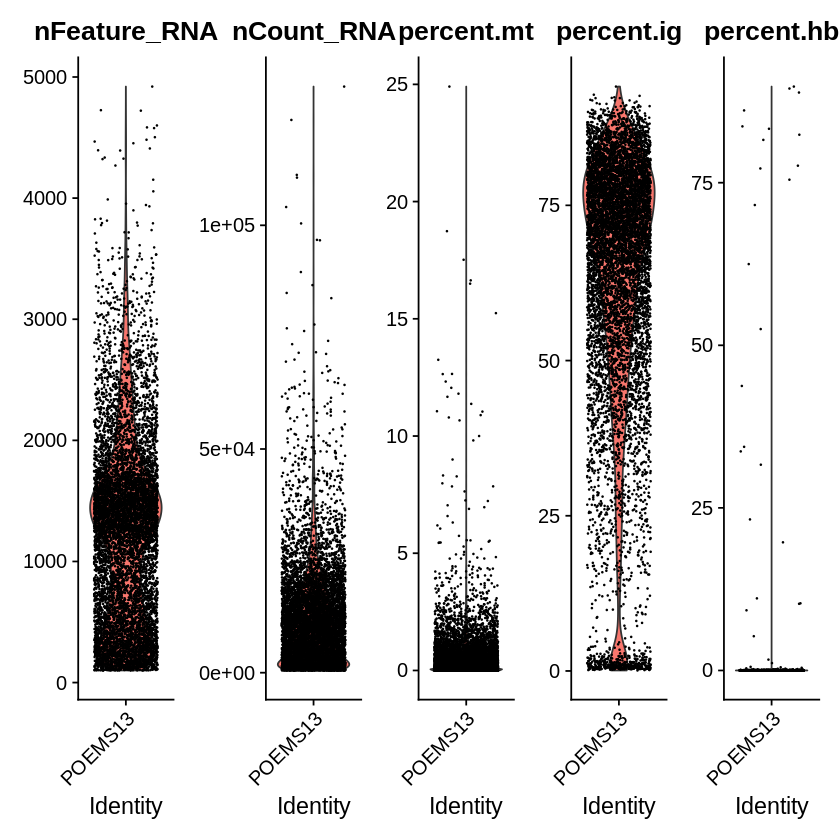

In [6]:
normal[["percent.mt"]] <- PercentageFeatureSet(normal, pattern = "^MT-")
normal[["percent.ig"]] <- PercentageFeatureSet(normal, pattern = "^IG")
normal[["percent.hb"]] <- PercentageFeatureSet(normal, pattern = "^HB")
VlnPlot(normal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.ig","percent.hb"), ncol = 5)

In [7]:
summary(normal@meta.data)

   orig.ident     nCount_RNA      nFeature_RNA      percent.mt      
 POEMS13:8511   Min.   :   501   Min.   : 100.0   Min.   : 0.00000  
                1st Qu.:  3365   1st Qu.: 577.5   1st Qu.: 0.04101  
                Median :  9368   Median :1284.0   Median : 0.26347  
                Mean   : 11532   Mean   :1231.2   Mean   : 0.53397  
                3rd Qu.: 16100   3rd Qu.:1639.5   3rd Qu.: 0.63865  
                Max.   :131007   Max.   :4921.0   Max.   :24.90566  
   percent.ig         percent.hb     
 Min.   : 0.08289   Min.   : 0.0000  
 1st Qu.:53.90763   1st Qu.: 0.0000  
 Median :69.46027   Median : 0.0000  
 Mean   :62.83538   Mean   : 0.1608  
 3rd Qu.:78.02988   3rd Qu.: 0.0000  
 Max.   :94.12781   Max.   :89.7819  

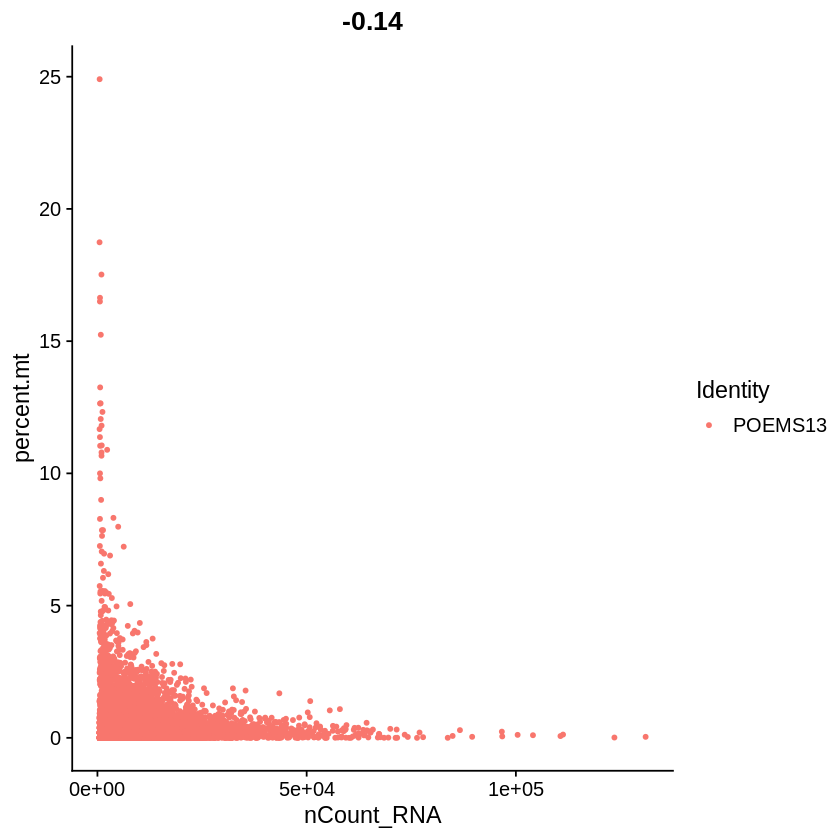

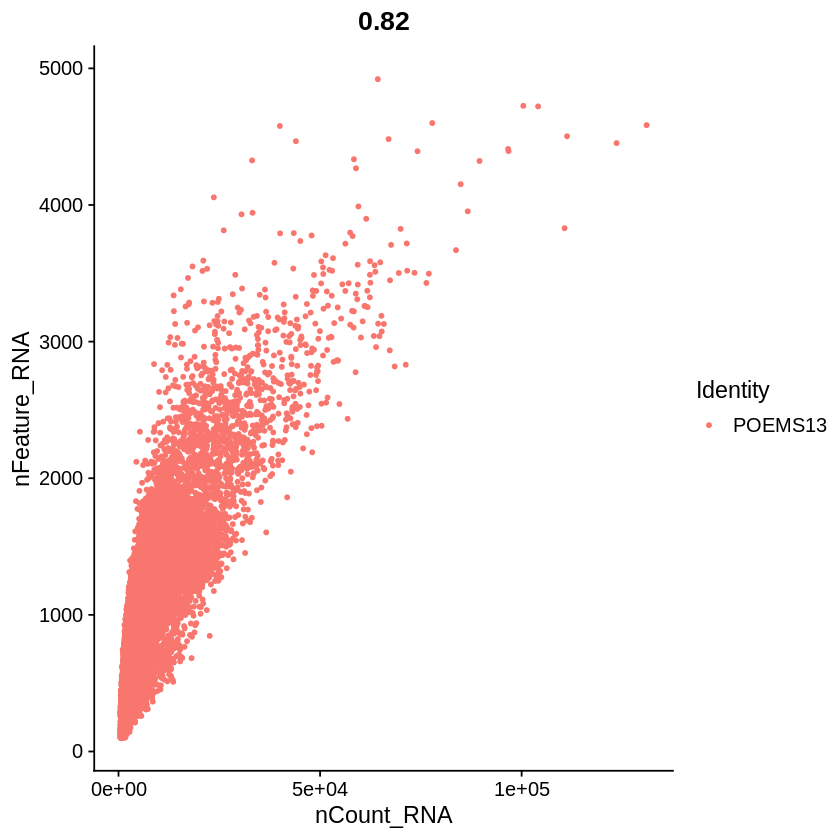

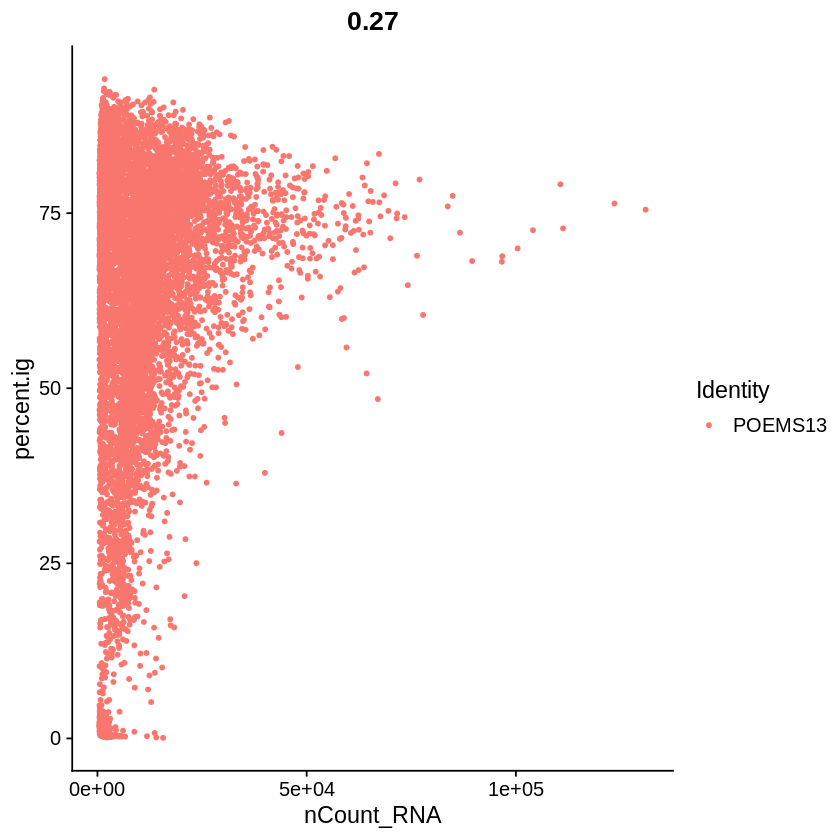

In [8]:
plot1 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.ig")
plot1
plot2
plot3

In [9]:
normal <- subset(normal, subset = nFeature_RNA > 100 & nFeature_RNA < 3000 & percent.mt < 5 & percent.hb<1)
normal

An object of class Seurat 
17479 features across 8255 samples within 1 assay 
Active assay: RNA (17479 features, 0 variable features)

In [10]:
all.genes <- rownames(normal)

In [11]:
normal <- NormalizeData(normal, normalization.method = "LogNormalize", scale.factor = 10000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


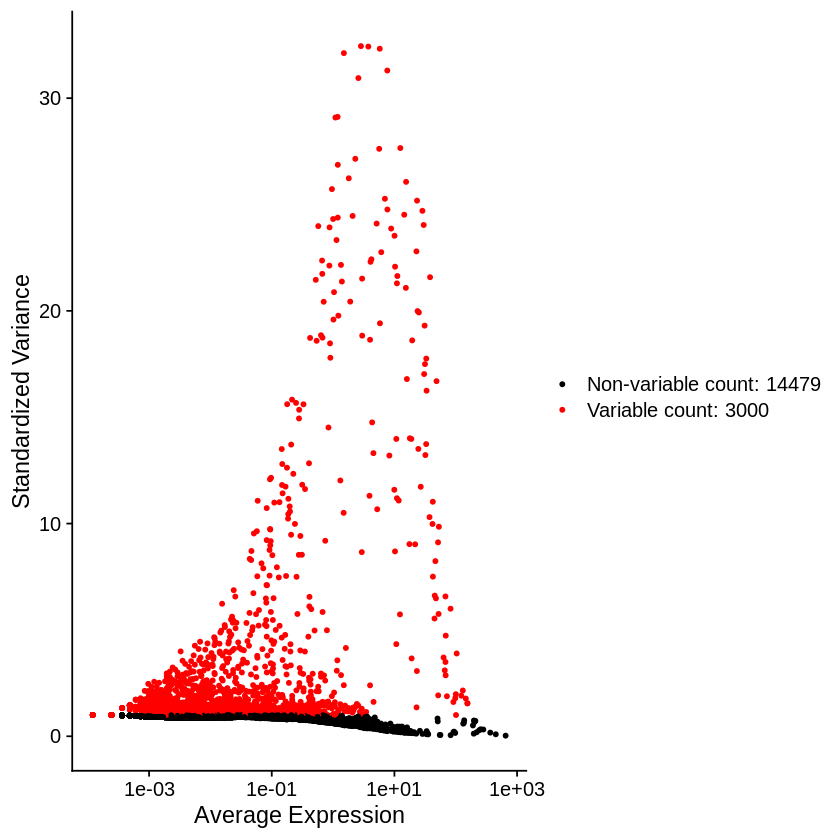

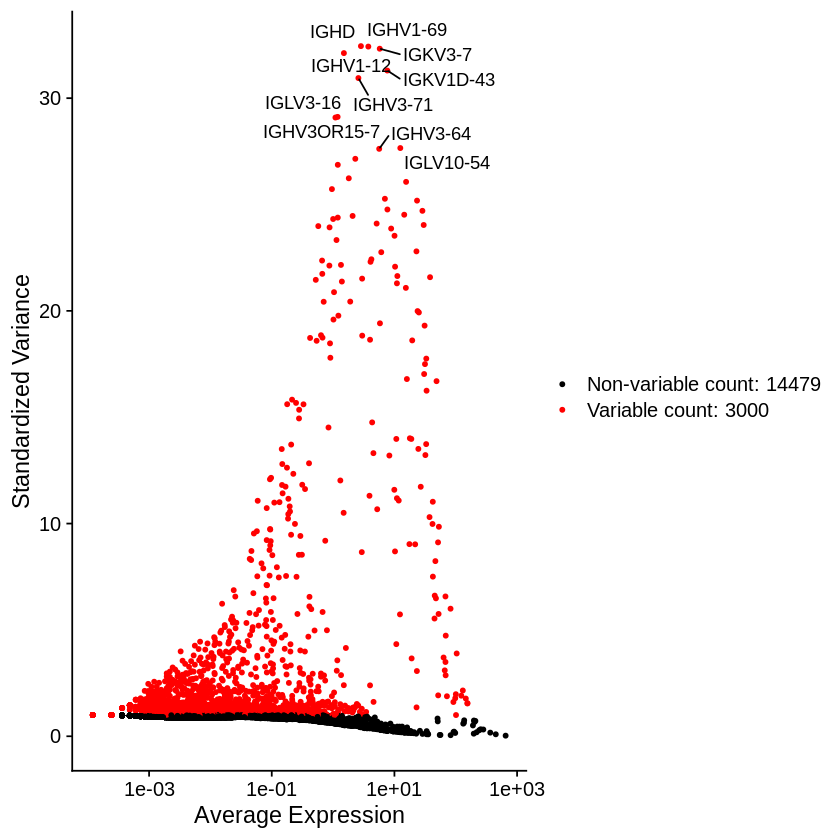

In [12]:
normal <- FindVariableFeatures(normal, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal)
plot2 <- LabelPoints(plot = plot1, points = top10,repel = TRUE)
plot1
plot2

In [13]:
all.genes <- rownames(normal)
normal <- ScaleData(normal, features = all.genes)

Centering and scaling data matrix



In [14]:
length(VariableFeatures(object = normal))

[1] 3000

In [15]:
normal <- RunPCA(normal, features = VariableFeatures(object = normal))

PC_ 1 
Positive:  IGHG4, IGLV3-1, JSRP1, DPEP1, CTHRC1, LMF1, IGHV3-7, PTP4A3, IGLV6-57, IGKV3D-11 
	   IGHG3, IGHV3-30, PAIP2B, IGHV4-59, IGKV3D-15, IGLV2-11, IGLC3, QPCT, BMP6, AC233755.1 
	   IGKV3D-20, IGHV4-61, IGHV3OR16-13, IGHV3-33, TNFRSF18, IGHV4-34, IGLC1, IGLV2-8, IGHV3-48, CERCAM 
Negative:  LYZ, FCN1, FCER1G, TYROBP, LST1, COTL1, AIF1, S100A9, ITGB2, TMSB4X 
	   HLA-DRA, IFITM3, S100A8, SERPINA1, CEBPD, SH3BGRL3, MNDA, LCP1, HLA-DPB1, LAPTM5 
	   HLA-DRB1, MS4A6A, S100A10, CORO1A, S100A4, ANXA1, ARPC1B, CD52, HLA-DRB5, SPI1 
PC_ 2 
Positive:  CITED2, MT-ND5, HSPA5, RHOB, ANKRD28, MT-ND1, ZFP36, ERN1, MT-ATP8, NFKBIA 
	   TRIB1, MT-ND2, MT-ND4, HSP90AA1, AC012236.1, MT-CO3, KLF6, IER2, SLC3A2, FOSB 
	   RRBP1, YPEL5, PELI1, DUSP5, HIST1H2BC, SQSTM1, CXCR4, ARID5B, JSRP1, HIST1H1C 
Negative:  LYZ, FCN1, AIF1, LST1, S100A9, FCER1G, S100A8, MNDA, TYROBP, SERPINA1 
	   MS4A6A, CEBPD, CD14, S100A12, CSTA, CLEC7A, C1orf162, FPR1, VCAN, MS4A7 
	   FGR, MAFB, CFP, LGALS2, TNFSF13B,

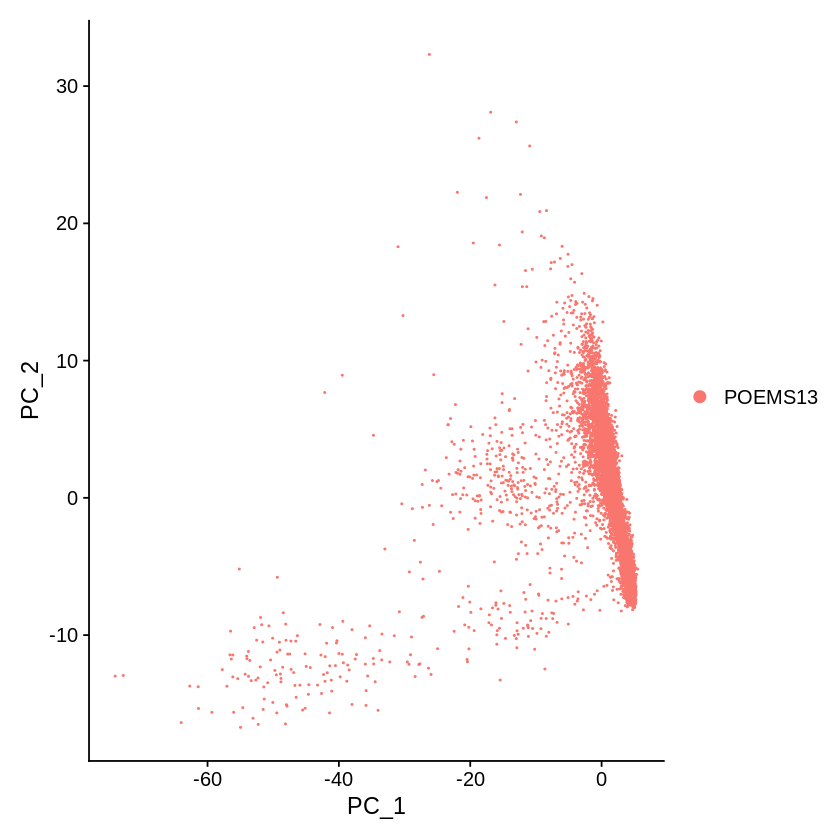

In [16]:
DimPlot(normal, reduction = "pca")

In [17]:
normal <- JackStraw(normal, num.replicate = 100)
normal <- ScoreJackStraw(normal, dims = 1:20)

Warning message:
“Removed 42298 rows containing missing values (geom_point).”


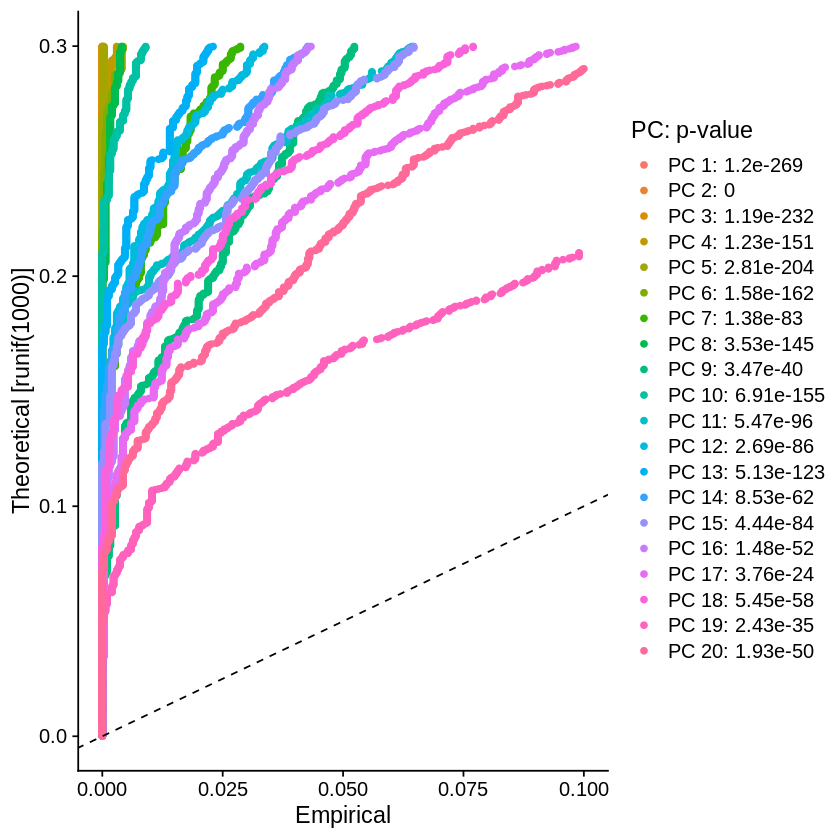

In [18]:
JackStrawPlot(normal, dims = 1:20)

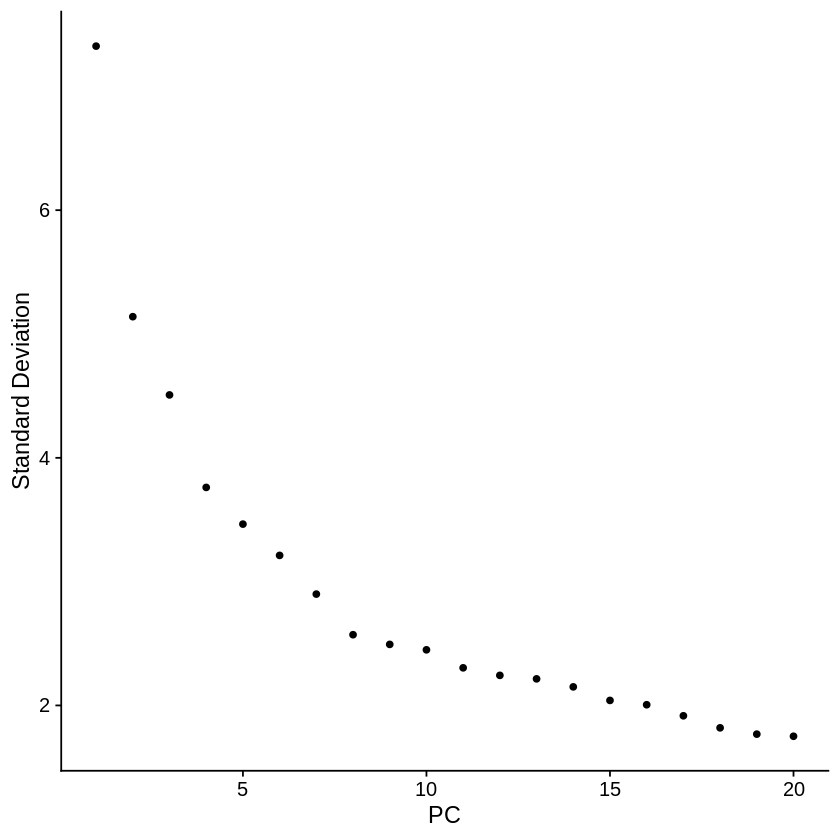

In [19]:
ElbowPlot(normal)

In [20]:
normal <- RunUMAP(normal, dims = 1:12)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:42:19 UMAP embedding parameters a = 0.9922 b = 1.112

14:42:19 Read 8255 rows and found 12 numeric columns

14:42:19 Using Annoy for neighbor search, n_neighbors = 30

14:42:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:42:20 Writing NN index file to temp file /tmp/RtmpuHkKoy/file72adc1a9e53cd

14:42:20 Searching Annoy index using 1 thread, search_k = 3000

14:42:22 Annoy recall = 100%

14:42:22 Commencing smooth kNN distance calibration using 1 thread

14:42:22 Initializing fr

In [21]:
options(repr.plot.height=8,repr.plot.width=8)

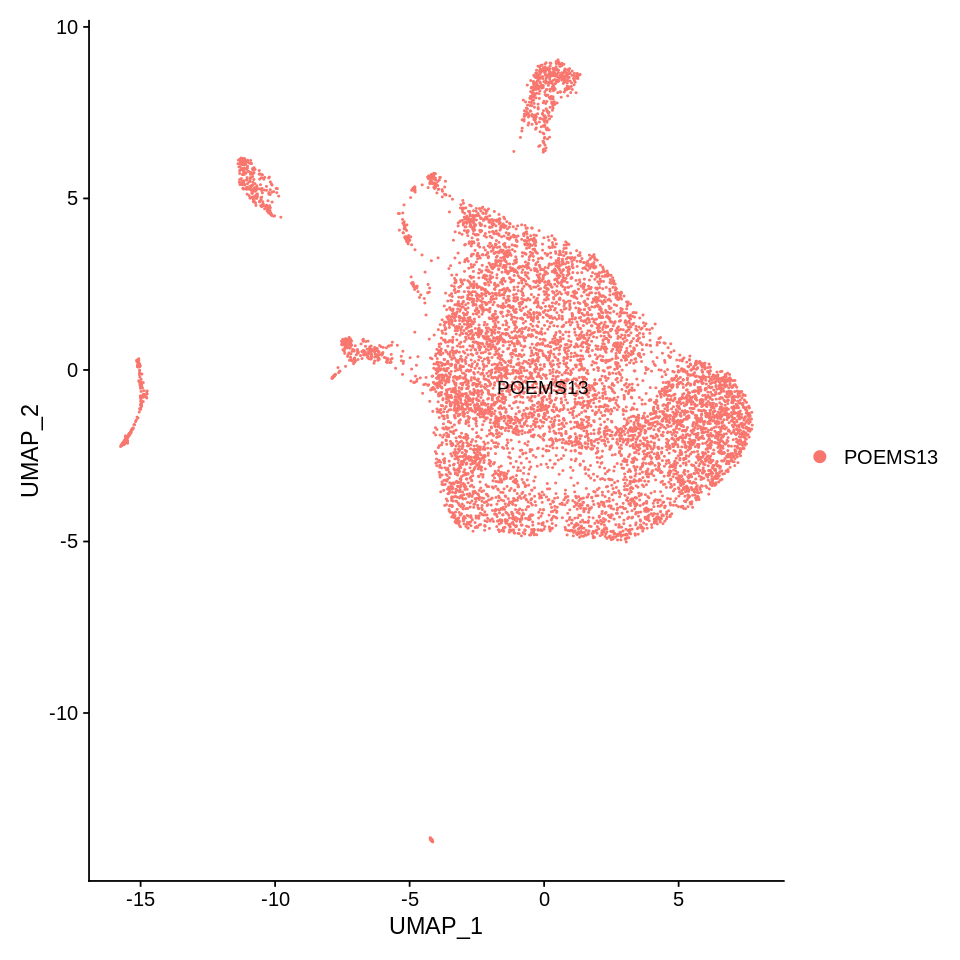

In [22]:
DimPlot(normal, reduction = "umap",label=T)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


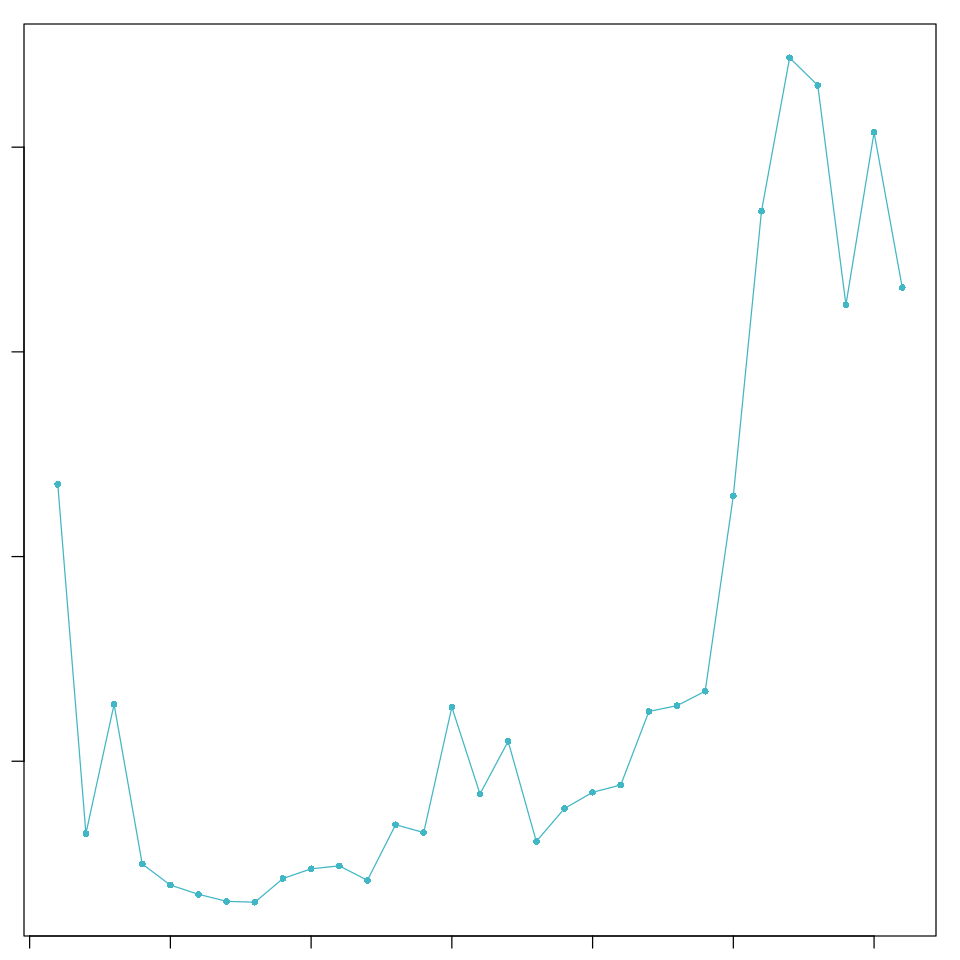

In [23]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(normal, PCs = 1:12, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(normal)))

In [24]:
normal <- doubletFinder_v3(normal, PCs = 1:12, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 2752 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [25]:
colnames(normal@meta.data)[ncol(normal@meta.data)]="DoubletFinder"

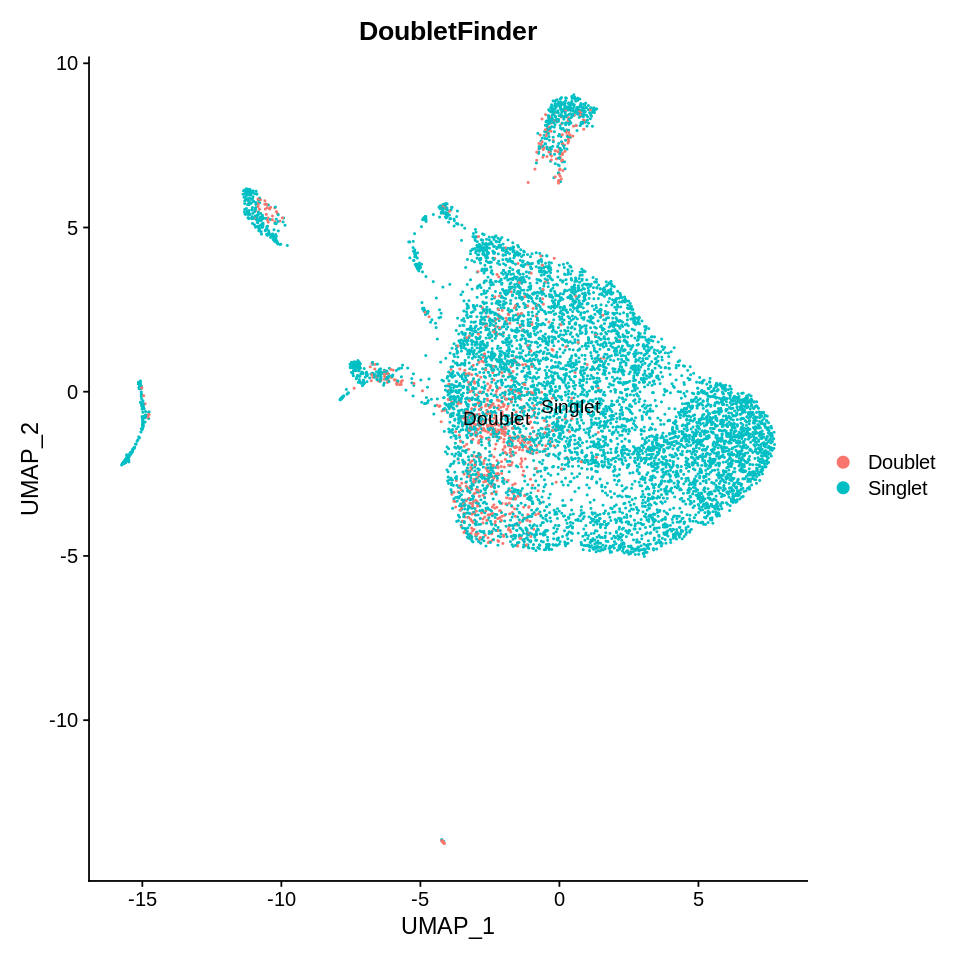

In [26]:
DimPlot(normal, reduction = "umap",label=T,group.by='DoubletFinder')

In [27]:
normal2<-subset(normal,DoubletFinder=='Singlet')

In [28]:
normal
normal2

An object of class Seurat 
17479 features across 8255 samples within 1 assay 
Active assay: RNA (17479 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
17479 features across 7429 samples within 1 assay 
Active assay: RNA (17479 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 52 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 52 rows containing missing values (geom_point).”


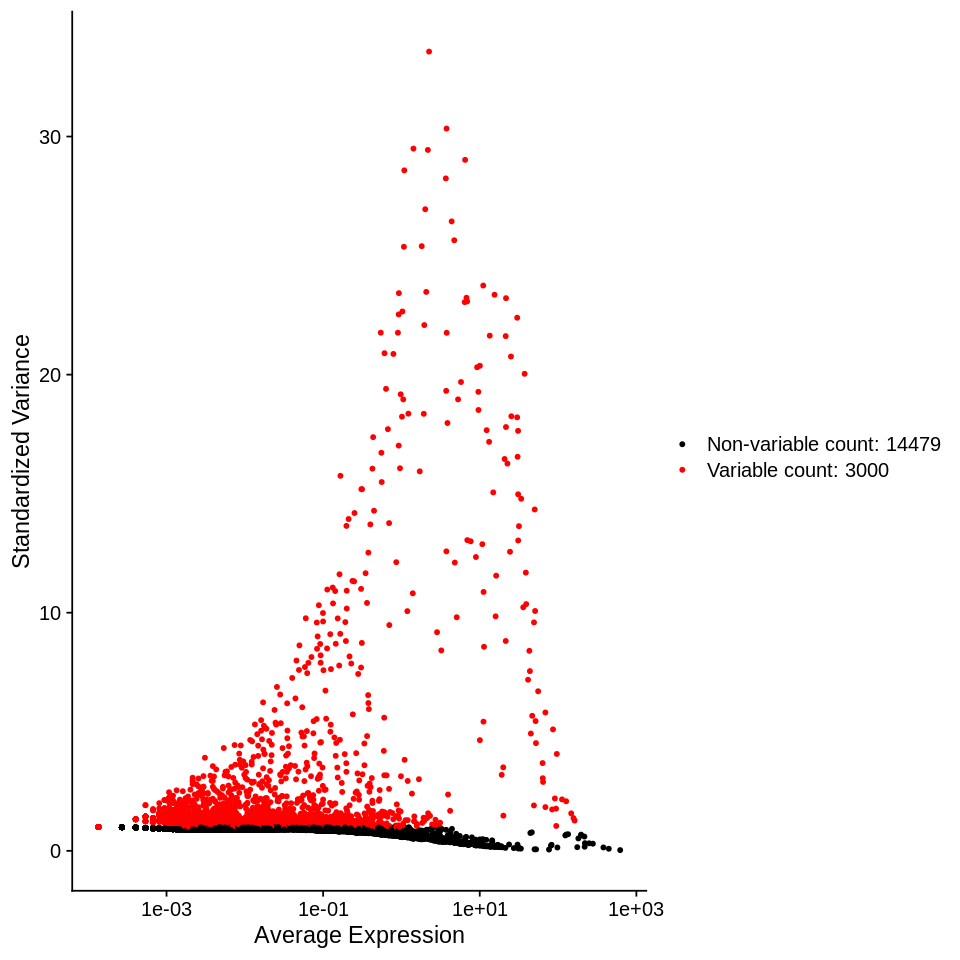

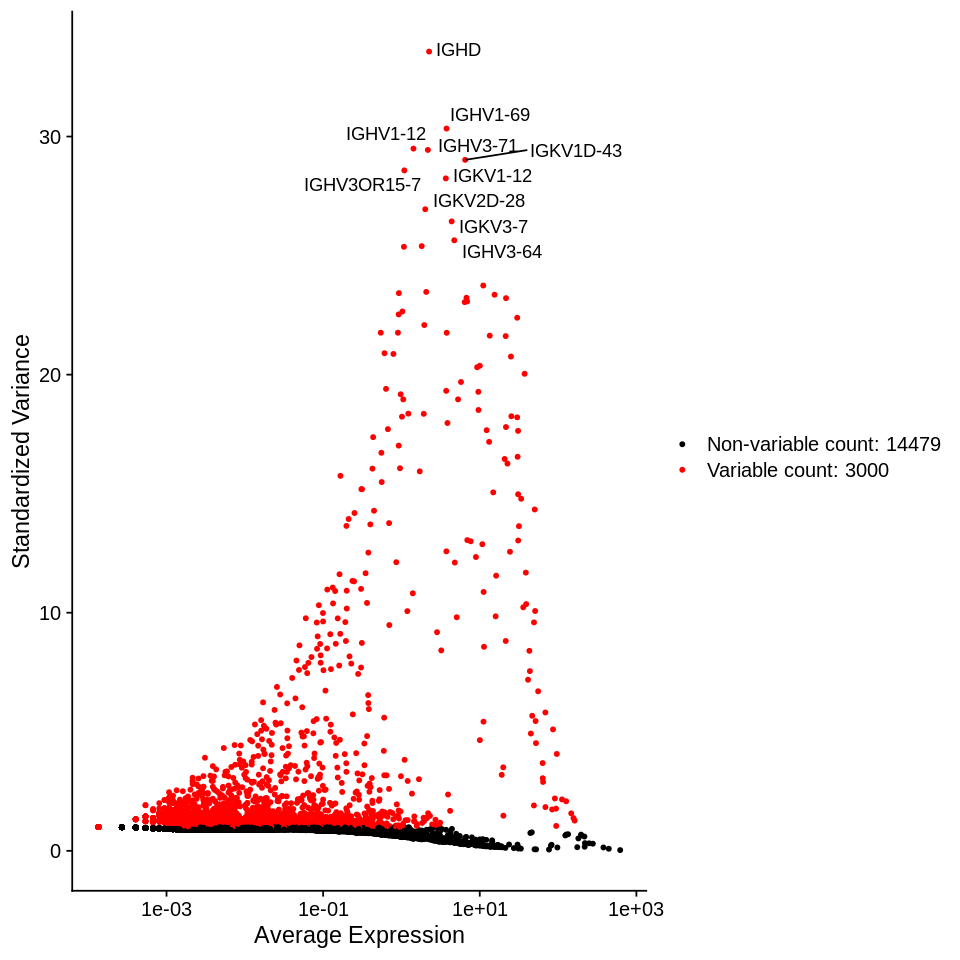

In [29]:
normal2 <- FindVariableFeatures(normal2, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [30]:
all.genes <- rownames(normal2)
normal2 <- ScaleData(normal2, features = all.genes)

Centering and scaling data matrix



In [31]:
normal2 <- RunPCA(normal2, features = VariableFeatures(object = normal2))

PC_ 1 
Positive:  LYZ, FCN1, TYROBP, FCER1G, COTL1, LST1, AIF1, S100A9, ITGB2, TMSB4X 
	   IFITM3, HLA-DRA, S100A8, SERPINA1, CEBPD, SH3BGRL3, MNDA, LCP1, LAPTM5, HLA-DRB1 
	   HLA-DPB1, S100A10, MS4A6A, CORO1A, S100A4, ARPC1B, CD52, ANXA1, SPI1, HLA-DRB5 
Negative:  IGHG4, IGLV3-1, JSRP1, DPEP1, CTHRC1, LMF1, IGHV3-7, IGLV6-57, PTP4A3, IGHG3 
	   IGKV3D-11, IGHV3-30, PAIP2B, IGHV4-59, IGLC3, IGKV3D-15, IGLV2-11, IGLC1, IGKV3D-20, QPCT 
	   AC233755.1, IGHV4-61, IGHV4-34, BMP6, IGHV3-33, TNFRSF18, IGHV3OR16-13, IGLV2-8, IGHV3-48, CERCAM 
PC_ 2 
Positive:  MT-ND5, CITED2, HSPA5, RHOB, MT-ATP8, ANKRD28, MT-ND1, ERN1, MT-ND2, ZFP36 
	   NFKBIA, MT-CO3, MT-ND4, TRIB1, AC012236.1, KLF6, TP53INP1, IER2, SLC3A2, ZBP1 
	   CXCR4, DUSP5, YPEL5, PELI1, RRBP1, HIST1H2BC, SQSTM1, ABCB9, FOSB, HIST1H1C 
Negative:  LYZ, FCN1, S100A9, AIF1, LST1, FCER1G, S100A8, TYROBP, MNDA, SERPINA1 
	   MS4A6A, CEBPD, CD14, S100A12, CLEC7A, CSTA, VCAN, FPR1, MS4A7, C1orf162 
	   MAFB, CFP, LGALS2, CFD, TNFSF13B, F

In [32]:
normal2 <- JackStraw(normal2, num.replicate = 100)
normal2 <- ScoreJackStraw(normal2, dims = 1:20)

Warning message:
“Removed 42316 rows containing missing values (geom_point).”


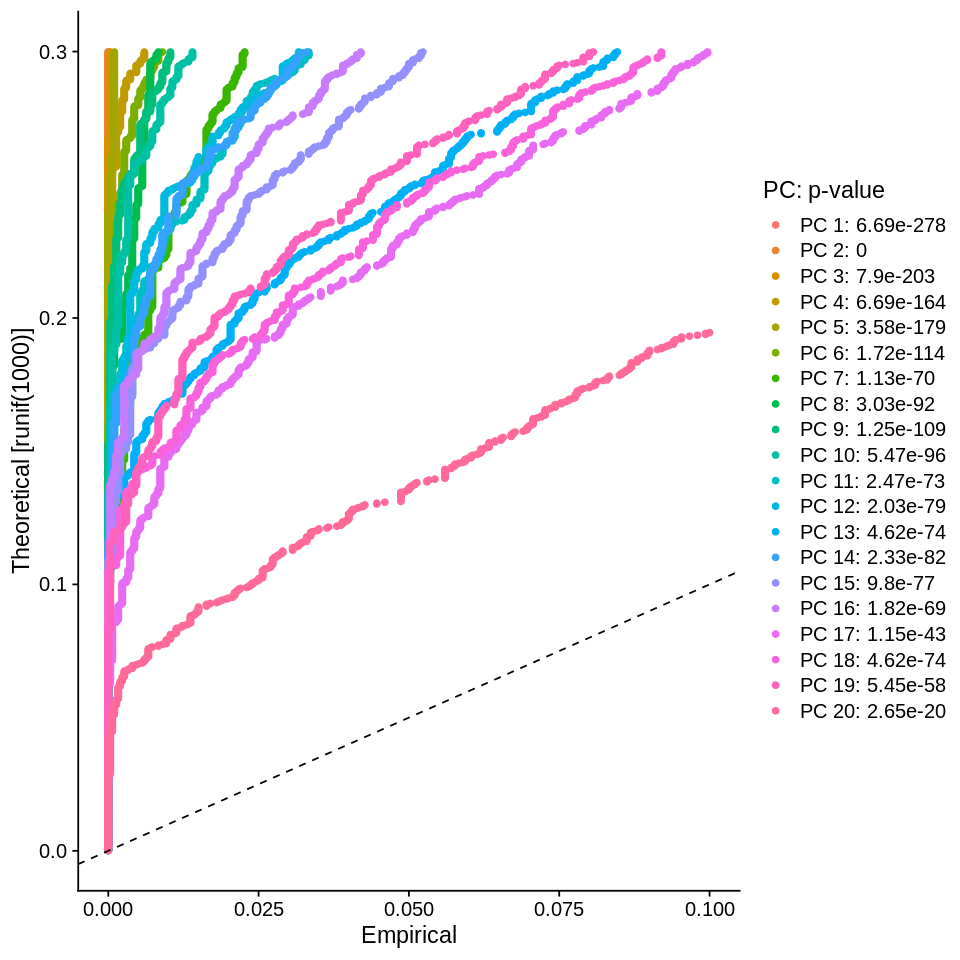

In [33]:
JackStrawPlot(normal2, dims = 1:20)

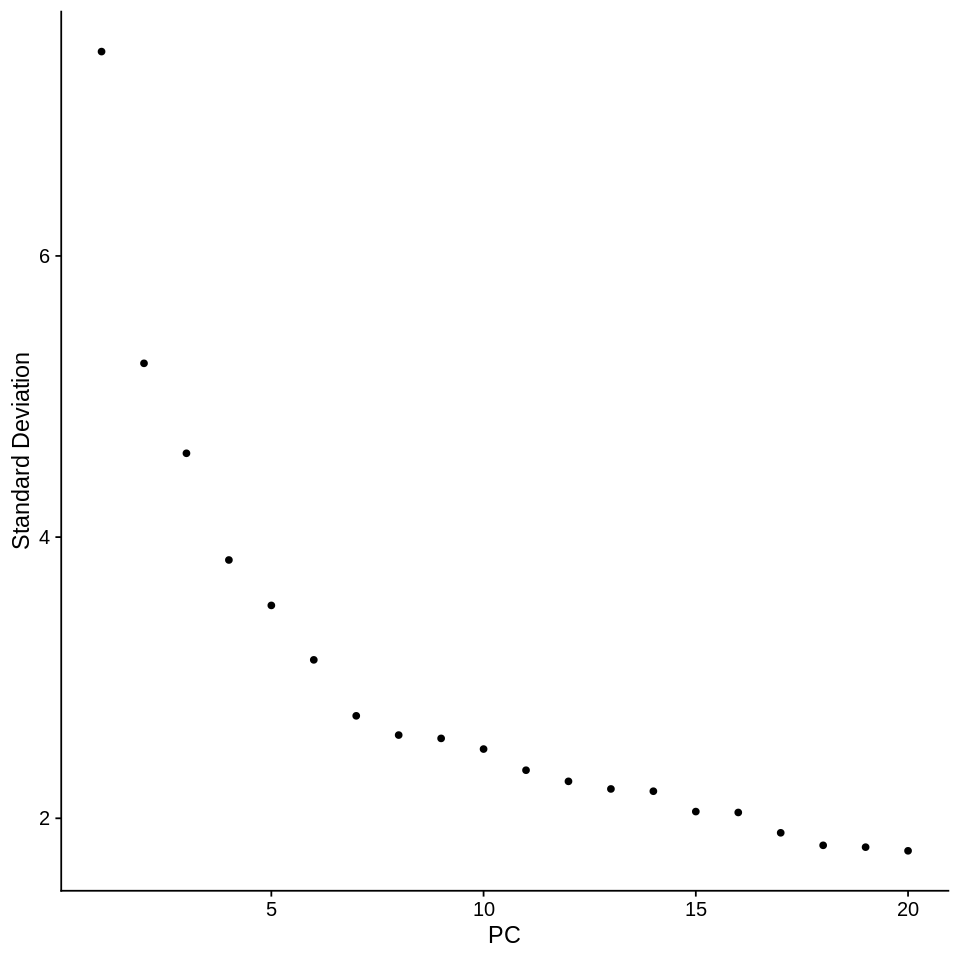

In [34]:
ElbowPlot(normal2)

In [35]:
normal2 <- FindNeighbors(normal2, dims = 1:12)
normal2 <- FindClusters(normal2, resolution = 0.6)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7429
Number of edges: 244339

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8383
Number of communities: 13
Elapsed time: 0 seconds


In [36]:
normal2 <- RunUMAP(normal2, dims = 1:12)

14:57:50 UMAP embedding parameters a = 0.9922 b = 1.112

14:57:50 Read 7429 rows and found 12 numeric columns

14:57:50 Using Annoy for neighbor search, n_neighbors = 30

14:57:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:57:51 Writing NN index file to temp file /tmp/RtmpuHkKoy/file72adc40e47dff

14:57:51 Searching Annoy index using 1 thread, search_k = 3000

14:57:53 Annoy recall = 100%

14:57:53 Commencing smooth kNN distance calibration using 1 thread

14:57:54 Initializing from normalized Laplacian + noise

14:57:54 Commencing optimization for 500 epochs, with 308422 positive edges

14:58:01 Optimization finished



In [37]:
options(repr.plot.height=8,repr.plot.width=8)

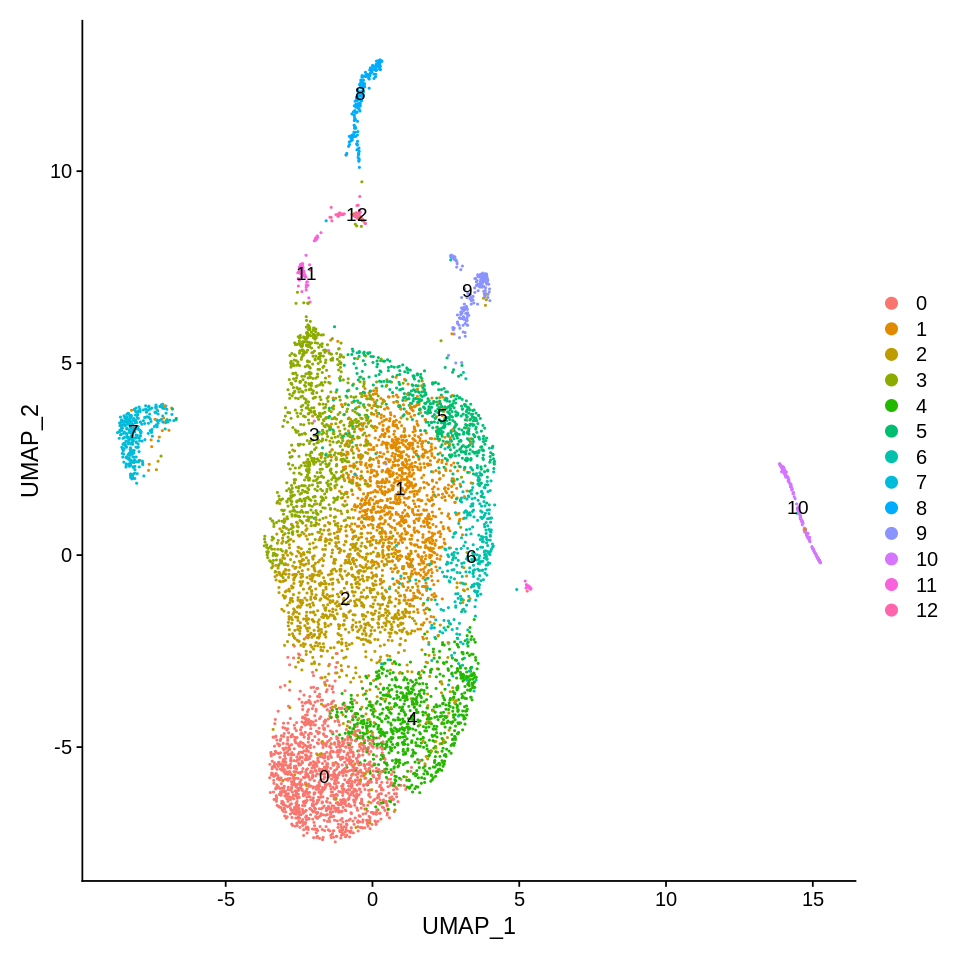

In [38]:
DimPlot(normal2, reduction = "umap",label=T)

In [39]:
options(repr.plot.height=9,repr.plot.width=7)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



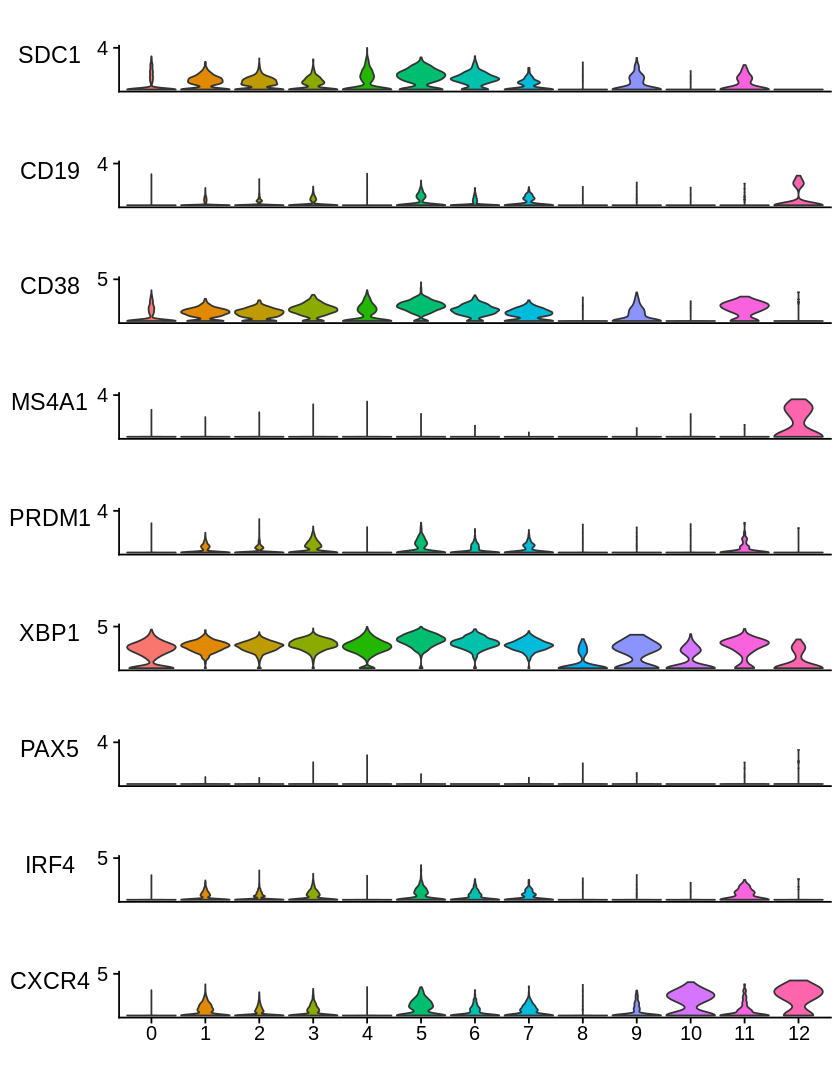

In [40]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



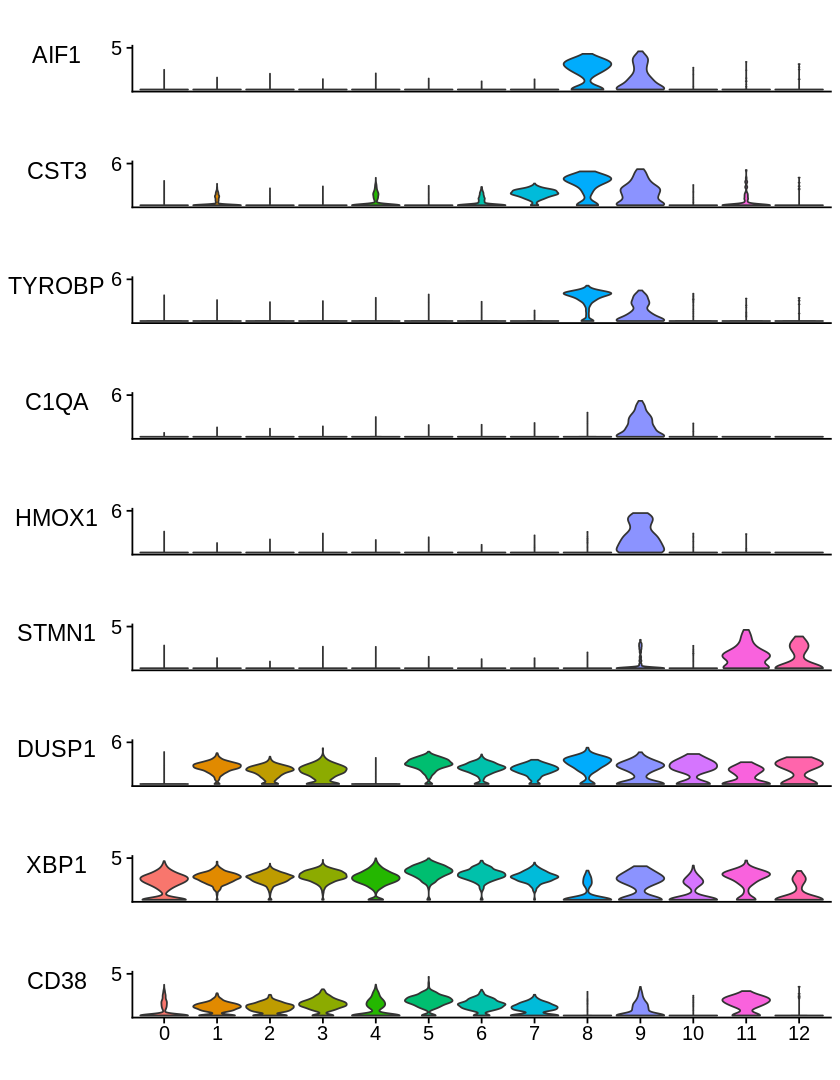

In [41]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =normal2, features = features)

In [42]:
options(repr.plot.height=6,repr.plot.width=6)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



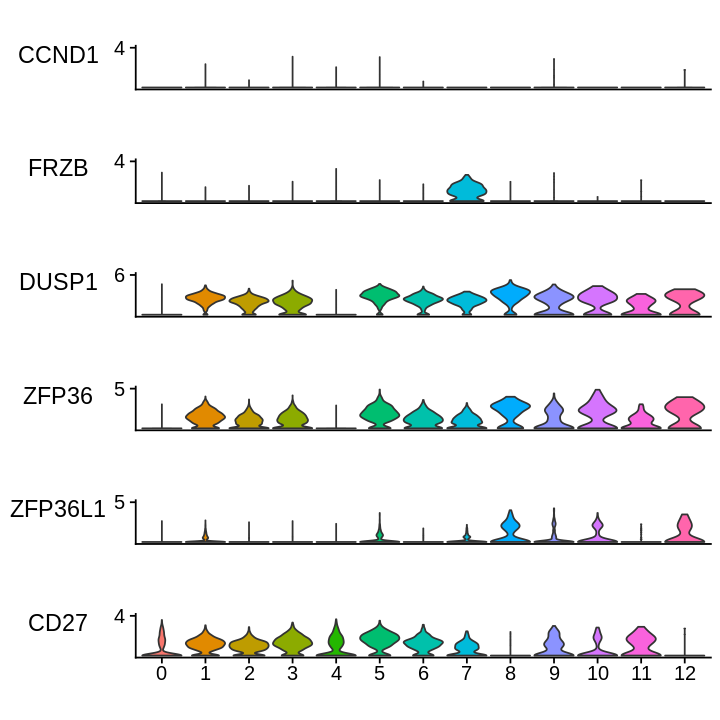

In [43]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =normal2, features = features)

In [44]:
options(repr.plot.height=4,repr.plot.width=8)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




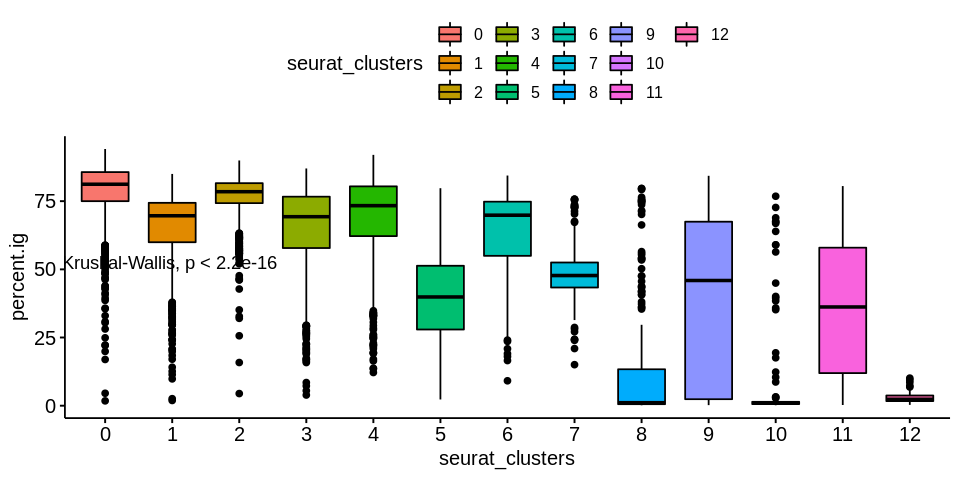

In [45]:
library(ggpubr)
library(RColorBrewer)
ggboxplot(normal2@meta.data, x="seurat_clusters", y="percent.ig", fill = "seurat_clusters")+
  stat_compare_means(label.y = 50)

In [46]:
normal3.markers <- FindAllMarkers(normal2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
normal3.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene     
1   2.238683e-19 0.8937825  0.599 0.623  3.912995e-15 0       IGLV2-14 
2   9.283327e-12 0.7942100  0.713 0.789  1.622633e-07 0       IGKV3-20 
3   4.409023e-08 1.1472515  0.498 0.542  7.706531e-04 0       IGLV1-40 
4   1.620176e-04 1.0121974  0.389 0.413  1.000000e+00 0       IGLV2-11 
5   1.229052e-03 0.6663667  0.488 0.671  1.000000e+00 0       IGLV3-1  
6  1.811380e-187 0.8946589  0.859 0.409 3.166110e-183 1       KLF6     
7  1.356231e-172 0.8952995  0.963 0.576 2.370556e-168 1       KLF2     
8   7.014137e-35 1.8324146  0.418 0.268  1.226001e-30 1       IGHM     
9   1.159703e-18 2.2814051  0.285 0.176  2.027045e-14 1       IGKV2-24 
10  1.764882e-08 0.9359469  0.367 0.280  3.084837e-04 1       IGKV3D-20
11  2.675751e-20 1.7586101  0.406 0.265  4.676945e-16 2       IGLV2-8  
12  2.792002e-16 0.6487141  0.673 0.680  4.880140e-12 2       IGKV1-5  
13  1.165300e-13 1.0896254  0.535 0.386  2.036827e-09 2       IGLV2-11 
14  2.268888e-12 0.9050423  0.527 0.392  3.965790e-08 2       IGLV2-23 
15  6.769636e-09 0.9407290  0.291 0.200  1.183265e-04 2       IGLV3-21 
16 6.365013e-177 0.9785575  0.997 0.667 1.112541e-172 3       MALAT1   
17  2.642670e-69 0.7396143  0.925 0.695  4.619122e-65 3       MT-CO2   
18  6.925902e-65 0.7772793  0.870 0.597  1.210578e-60 3       MT-CO1   
19  1.681835e-11 0.9888690  0.476 0.368  2.939680e-07 3       IGLC3    
20  6.247107e-10 1.5350363  0.323 0.230  1.091932e-05 3       IGHA2    
21  4.793540e-31 1.8569533  0.265 0.127  8.378628e-27 4       IGKV1-39 
22  5.080269e-24 1.9657409  0.251 0.133  8.879803e-20 4       IGKV1D-39
23  5.081423e-24 2.1077330  0.320 0.198  8.881820e-20 4       IGKV1-9  
24  5.904354e-22 1.9622889  0.363 0.244  1.032022e-17 4       IGKV1-6  
25  1.204696e-13 2.5679028  0.259 0.174  2.105688e-09 4       IGKV1-27 
26 7.366876e-133 1.8130260  0.998 0.685 1.287656e-128 5       MALAT1   
27 8.362868e-100 2.8298576  0.426 0.123  1.461746e-95 5       IGKV1D-39
28  2.679926e-97 2.6907851  0.414 0.119  4.684243e-93 5       IGKV1-39 
29  1.144298e-23 1.9615541  0.632 0.477  2.000118e-19 5       IGHG3    
30  1.683664e-20 1.8036477  0.291 0.152  2.942876e-16 5       IGHV4-31 
⋮  ⋮             ⋮          ⋮     ⋮     ⋮             ⋮       ⋮        
36  0.000000e+00 2.562616   0.986 0.087  0.000000e+00 7       IGLV1-36 
37 3.422743e-216 6.274361   0.993 0.418 5.982613e-212 7       IGHV3-43 
38 7.297689e-215 2.963553   0.973 0.341 1.275563e-210 7       SLC3A2   
39 3.781806e-186 2.313251   1.000 0.443 6.610219e-182 7       IGLV1-44 
40 3.442672e-166 2.402150   0.990 0.487 6.017446e-162 7       IGLC1    
41  0.000000e+00 7.654013   0.965 0.012  0.000000e+00 8       S100A9   
42  0.000000e+00 7.177162   0.916 0.011  0.000000e+00 8       S100A8   
43  0.000000e+00 5.643788   0.837 0.005  0.000000e+00 8       LYZ      
44  0.000000e+00 4.830957   0.901 0.048  0.000000e+00 8       TYROBP   
45  0.000000e+00 4.520082   0.550 0.002  0.000000e+00 8       S100A12  
46  0.000000e+00 5.122016   0.782 0.037  0.000000e+00 9       HMOX1    
47  0.000000e+00 4.314645   0.764 0.027  0.000000e+00 9       APOE     
48  0.000000e+00 3.729601   0.673 0.008  0.000000e+00 9       C1QA     
49  1.140562e-84 4.478955   1.000 0.968  1.993589e-80 9       FTL      
50  2.046328e-70 3.785274   0.988 0.891  3.576777e-66 9       FTH1     
51  0.000000e+00 5.038337   0.567 0.003  0.000000e+00 10      NKG7     
52  0.000000e+00 4.841007   0.924 0.003  0.000000e+00 10      IL32     
53  0.000000e+00 4.325064   0.548 0.011  0.000000e+00 10      CCL5     
54  0.000000e+00 4.007327   0.280 0.001  0.000000e+00 10      GNLY     
55  0.000000e+00 3.859219   0.592 0.012  0.000000e+00 10      LTB      
56 3.154363e-180 3.043795   0.702 0.042 5.513511e-176 11      STMN1    
57  1.770007e-90 4.463447   0.286 0.013  3.093795e-86 11      NRGN     
58  2.063327e-52 3.192716   0.857 0.289  3.606489e-48 11      TUBA1B   
59  7.910978e-37 2.863657   0.762 0.245  1.

In [47]:
options(repr.plot.height=10,repr.plot.width=10)

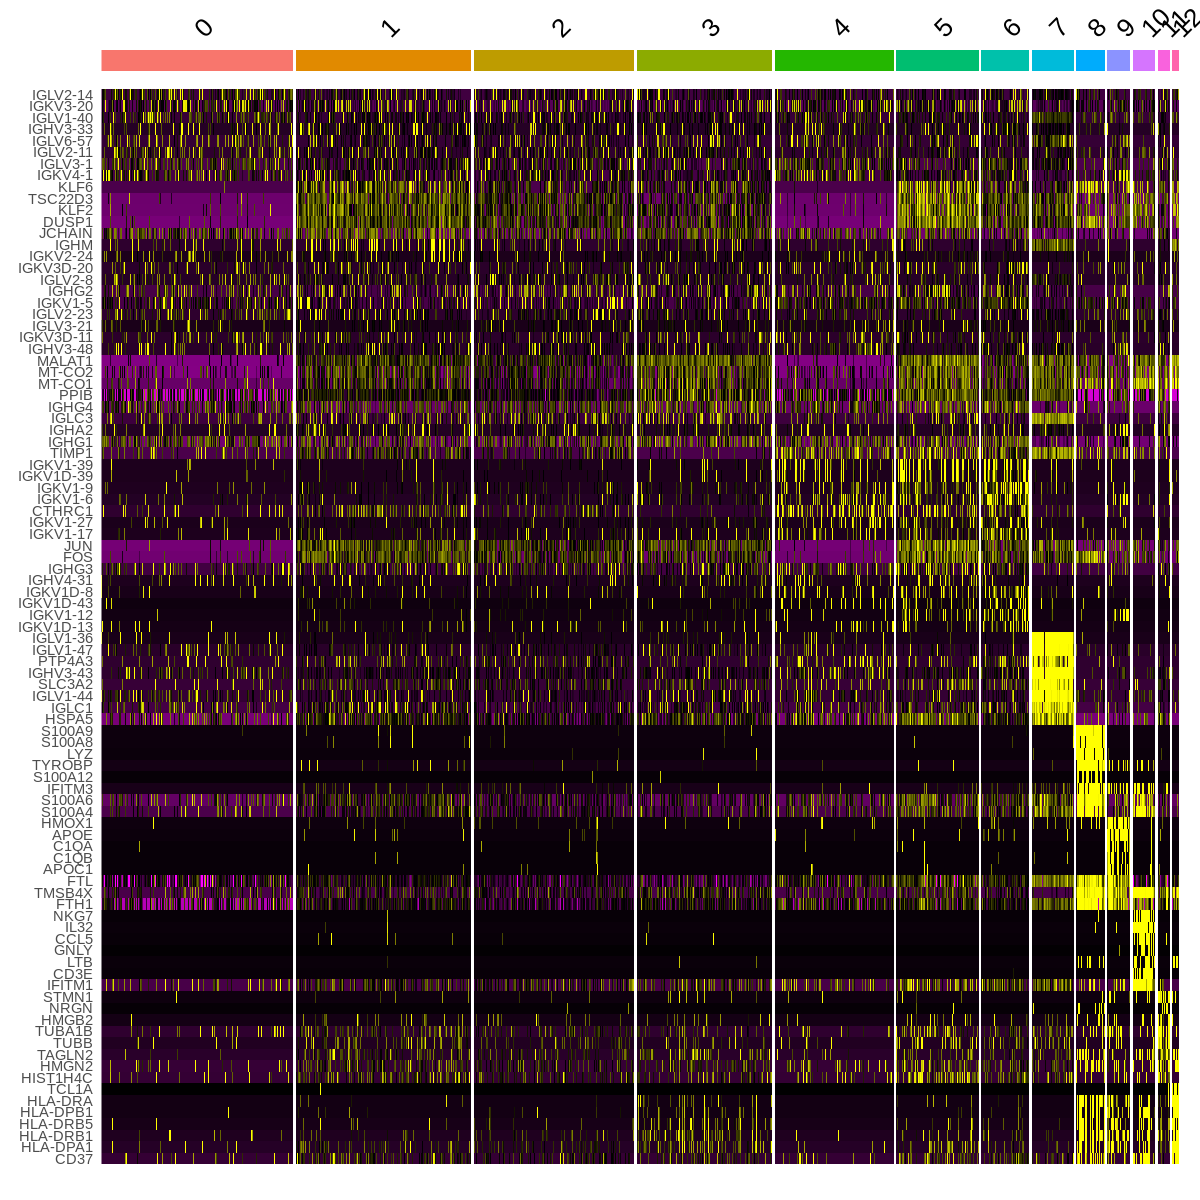

In [48]:
top10 <- normal3.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(normal2, features = top10$gene) + NoLegend()

In [49]:
load('/together_sdb/zhoujiaqi/sc0418/RNA/imgs.xxy/HPCA.Rdata')
load('/together_sdb/zhoujiaqi/sc0418/RNA/imgs.xxy/NHD.RData')                       
library(Seurat)
library(SingleR)
library(viridis)
library(pheatmap)

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4


Attaching package: ‘stats4’


The following object is masked from ‘package:spam’:

    mle


Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:spam’:

    cbind, rbind


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filte

In [50]:
normal2_for_SingleR <- GetAssayData(normal2, slot="data") 

In [51]:
clusterann<-SingleR(normal2_for_SingleR, nhd.se, method="cluster", clusters=normal2@meta.data$seurat_clusters,labels=nhd.se$label.main)
clusterann<-as.data.frame(row.names=clusterann@rownames,clusterann$labels)
clusterann

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 29”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 6”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 21”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 24”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 4”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 10”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 5”
Warning message:
“Argument 'center' should b

clusterann$labels
0  B cells          
1  B cells          
2  B cells          
3  B cells          
4  B cells          
5  B cells          
6  B cells          
7  B cells          
8  Monocytes        
9  B cells          
10 CD8+ T cells     
11 B cells          
12 B cells

In [52]:
normal2.nhsc <- SingleR(test = normal2_for_SingleR, ref= nhd.se, labels = nhd.se$label.main) 

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 29”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 6”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 21”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 24”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 4”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 10”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 5”
Warning message:
“Argument 'center' should b

In [53]:
meta=normal2@meta.data
table(normal2.nhsc$labels,meta$seurat_clusters)
normal2@meta.data$labels <-normal2.nhsc$labels

                 
                     0    1    2    3    4    5    6    7    8    9   10   11
  B cells          952 1222 1099  928  650  575  324  286   16   77    2   64
  Basophils        100   15   28   27   37   10   17    2    1    5    0    4
  CD4+ T cells       1    0    0    0    0    0    0    0    0    0   53    0
  CD8+ T cells       3    1    0    0    0    0    0    0    0    0   79    0
  CMPs              40    0    1    0   24    0    1    0    1    0    0    0
  Dendritic cells   70    4    2    3   26    0    0    2    2   13    0    1
  Eosinophils      125    2    8    3   58    0    1    2    1    7    0    2
  Erythroid cells    1    0    0    0    0    0    0    0    0    0    0    1
  GMPs               0    0    0    0    0    0    0    0    0    1    0    0
  Granulocytes      35    0    0    1   14    0    0    0    6    0    0    0
  Megakaryocytes     1    0    0    0    0    0    0    0    0    0    0   10
  MEPs               0    0    0    0    0    

In [54]:
type<-as.data.frame(normal2.nhsc$labels)
count<-table(type)
count

type
        B cells       Basophils    CD4+ T cells    CD8+ T cells            CMPs 
           6233             249              54              83              69 
Dendritic cells     Eosinophils Erythroid cells            GMPs    Granulocytes 
            127             209               2               1              56 
 Megakaryocytes            MEPs       Monocytes        NK cells      NK T cells 
             11               1             300              28               6 

In [55]:
names<-as.vector(rownames(normal2@meta.data))
type2<-type[names,]

In [56]:
options(repr.plot.height=8,repr.plot.width=8)

In [70]:
plasma<-subset(normal2,ident=c(0,1,2,3,4,5,6,7,11,12))

In [71]:
plasma

An object of class Seurat 
17479 features across 6905 samples within 1 assay 
Active assay: RNA (17479 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

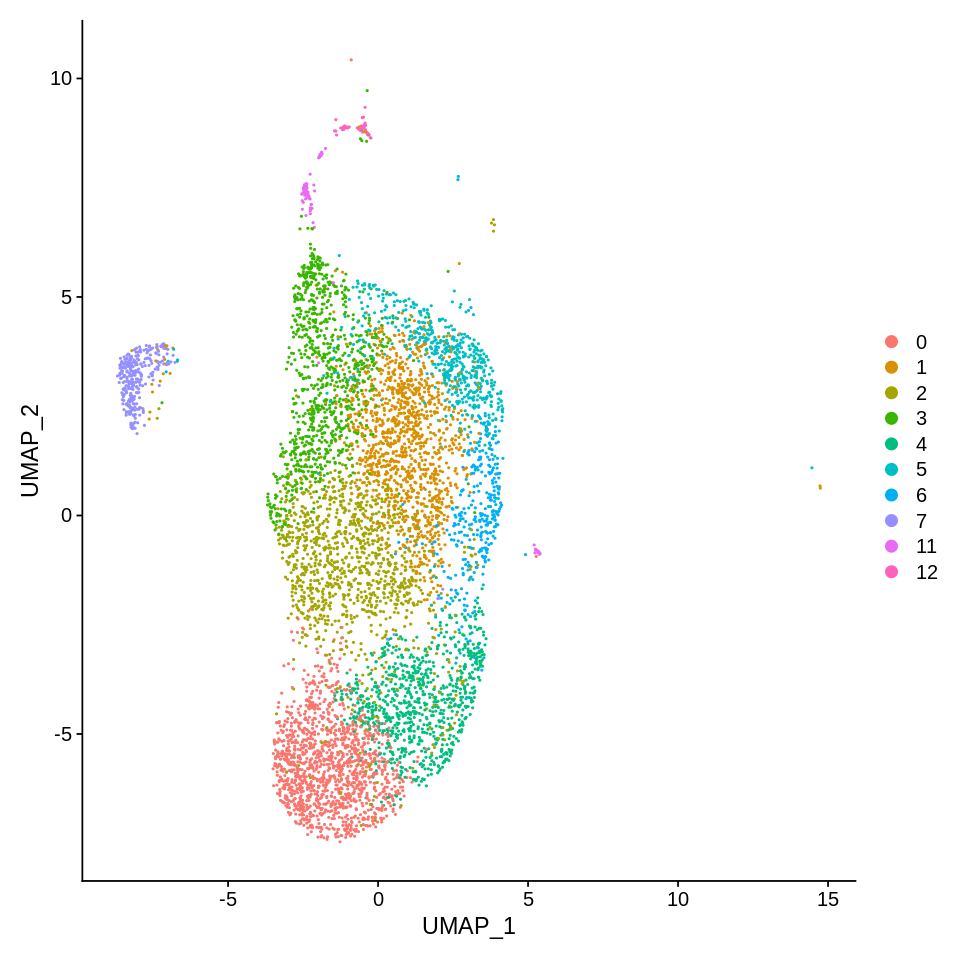

In [72]:
DimPlot(plasma, reduction = "umap")

In [73]:
plasma <- FindNeighbors(plasma, dims = 1:10)
plasma <- FindClusters(plasma, resolution = 0.6)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6905
Number of edges: 230461

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8266
Number of communities: 10
Elapsed time: 0 seconds


In [74]:
plasma <- RunUMAP(plasma, dims = 1:10)

15:18:59 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

15:18:59 Read 6905 rows and found 10 numeric columns

15:18:59 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

15:18:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:18:59 Writing NN index file to temp file /tmp/RtmpuHkKoy/file72adc4658efd8

15:18:59 Searching Annoy index using 1 thread, search_k = 3000

15:19:01 Annoy recall = 100%

15:19:02 Commencing smooth kNN distance calibration using 1 thread

15:19:03 Initializing from normalized Laplacian + noise

15:19:03 Commencing opt

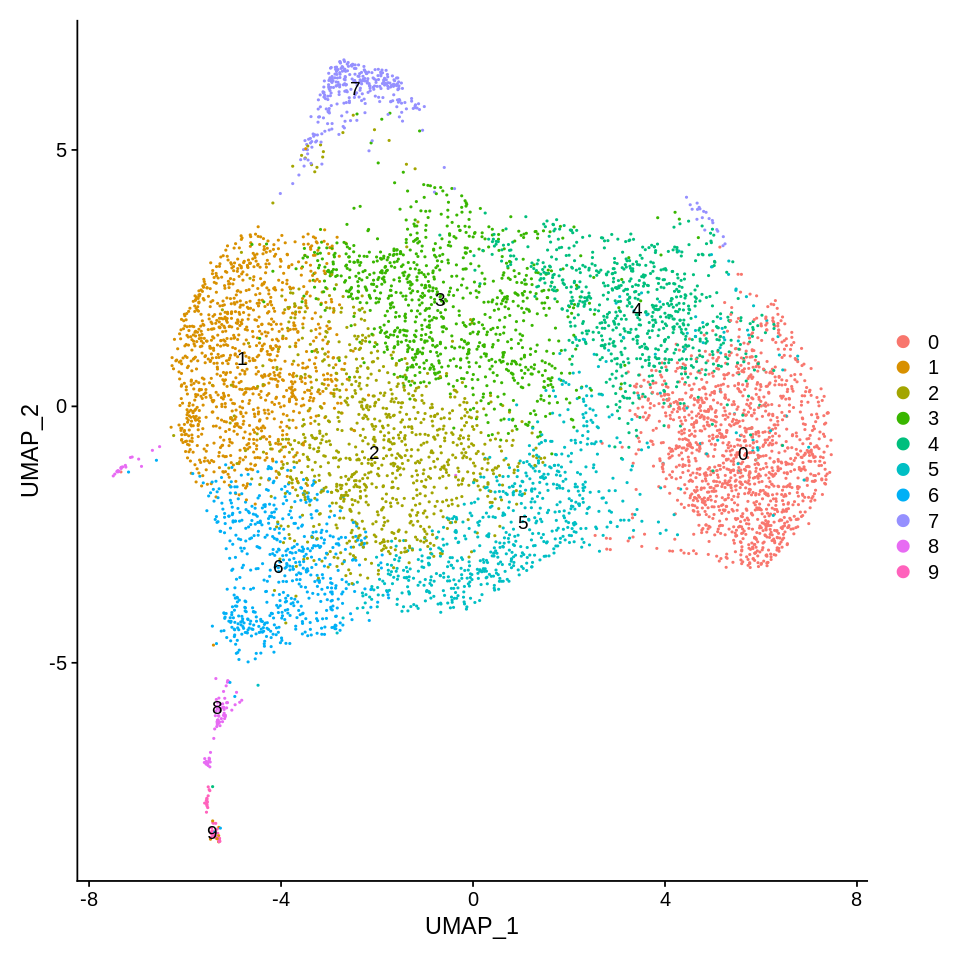

In [75]:
options(repr.plot.height=8,repr.plot.width=8)
DimPlot(plasma, reduction = "umap",label=T)

In [86]:
plasma<-subset(plasma,ident=c(0,1,2,3,4,5,6,7,8))

In [101]:
plasma

An object of class Seurat 
17479 features across 6859 samples within 1 assay 
Active assay: RNA (17479 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

In [102]:
plasma <- FindNeighbors(plasma, dims = 1:10)
plasma <- FindClusters(plasma, resolution = 0.6)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6859
Number of edges: 229593

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8235
Number of communities: 9
Elapsed time: 0 seconds


In [103]:
plasma <- RunUMAP(plasma, dims = 1:10)

15:41:05 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

15:41:05 Read 6859 rows and found 10 numeric columns

15:41:05 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

15:41:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:41:06 Writing NN index file to temp file /tmp/RtmpuHkKoy/file72adc17da22f1

15:41:06 Searching Annoy index using 1 thread, search_k = 3000

15:41:08 Annoy recall = 100%

15:41:08 Commencing smooth kNN distance calibration using 1 thread

15:41:10 Initializing from normalized Laplacian + noise

15:41:10 Commencing opt

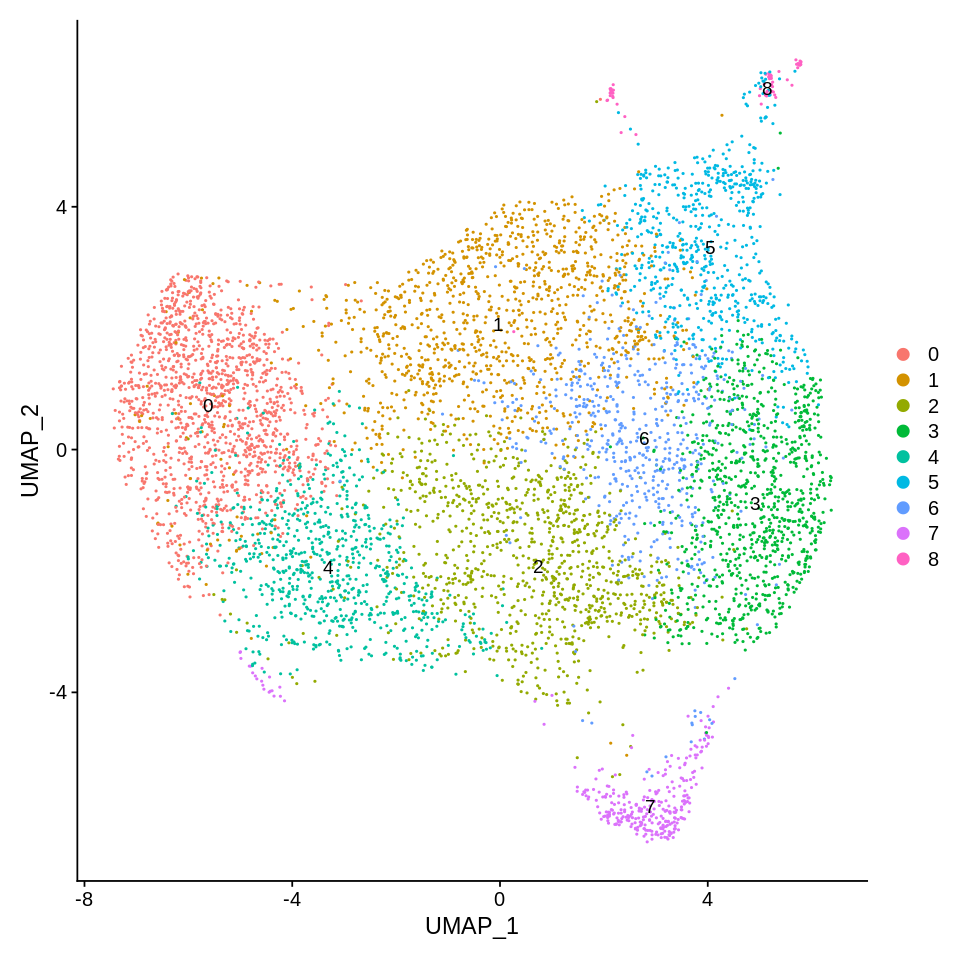

In [104]:
options(repr.plot.height=8,repr.plot.width=8)
DimPlot(plasma, reduction = "umap",label=T)

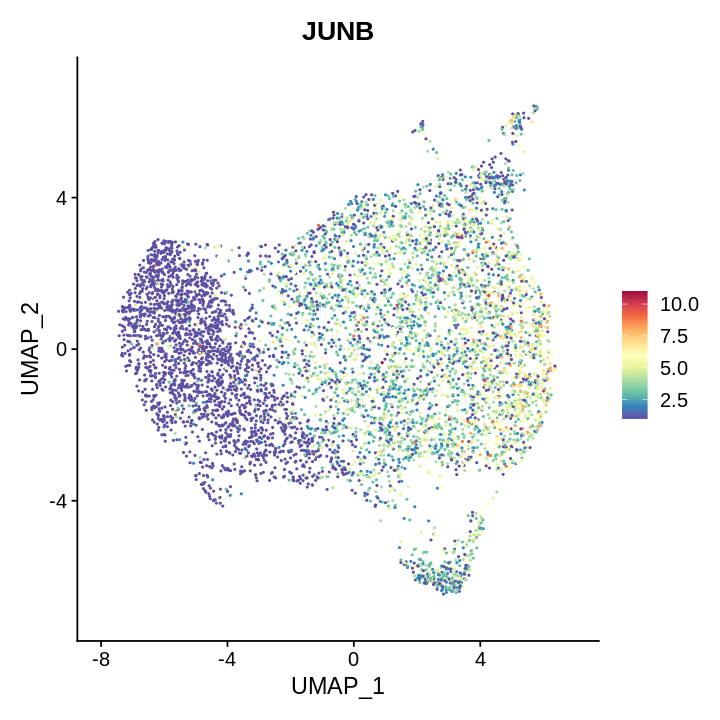

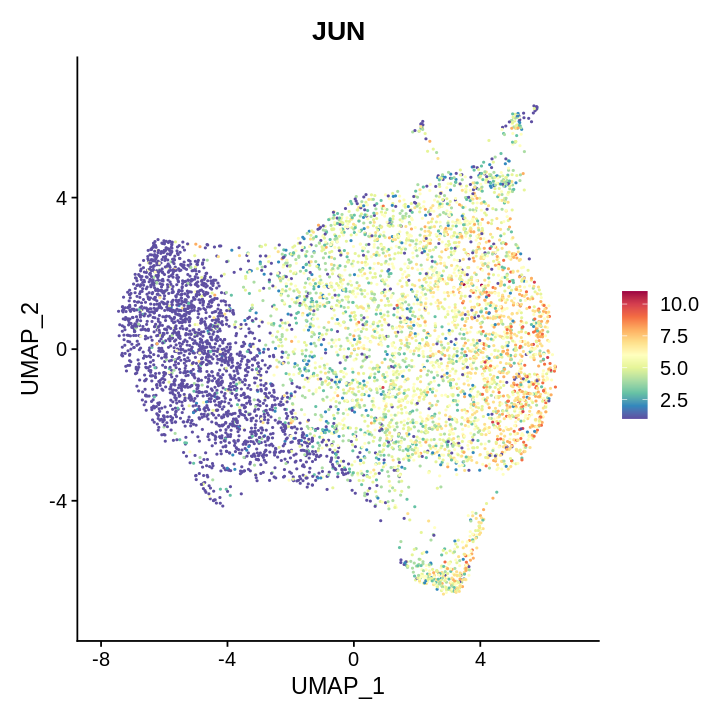

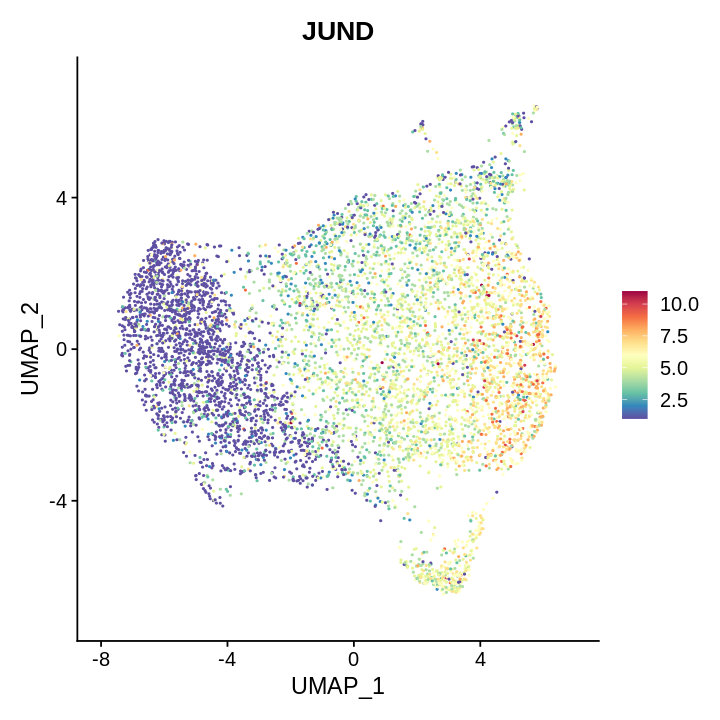

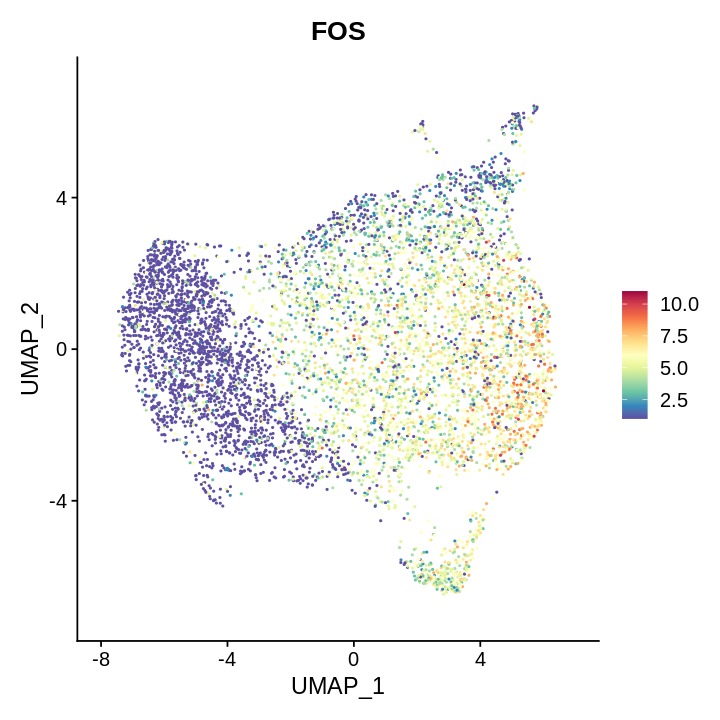

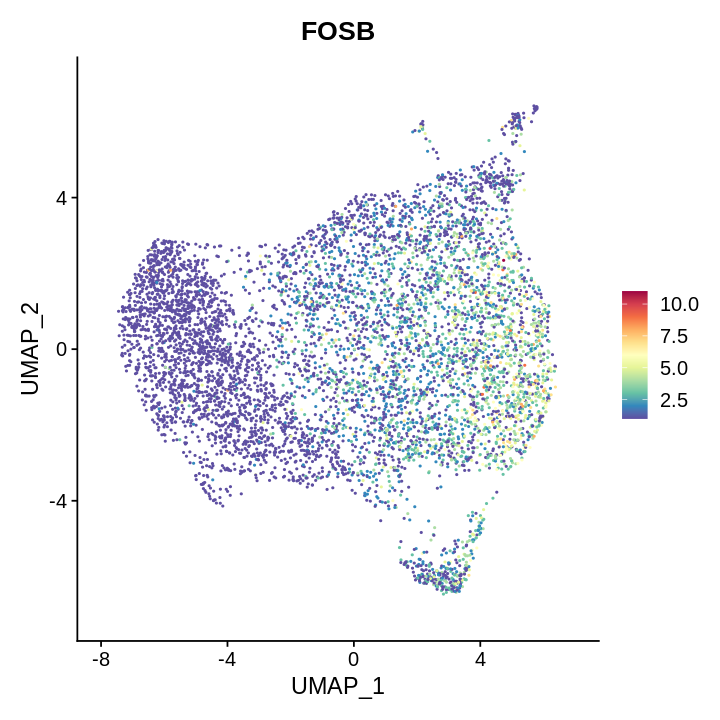

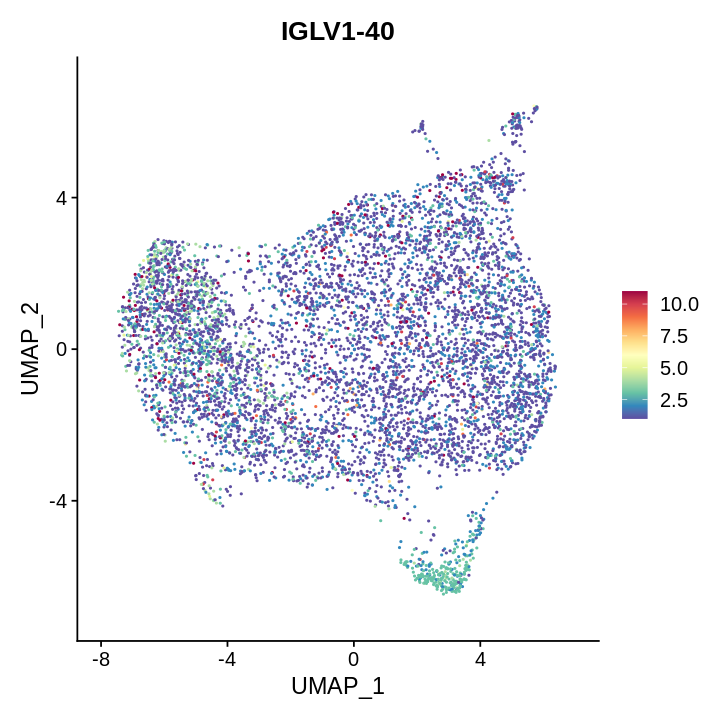

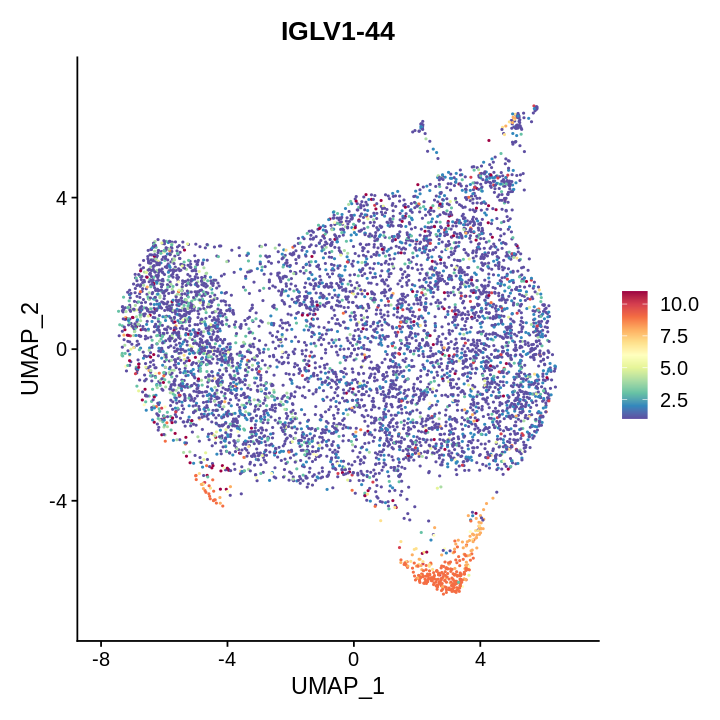

In [105]:
options(repr.plot.height=6,repr.plot.width=6)
FeaturePlot(plasma, features = c('JUNB'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('JUN'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('JUND'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('FOS'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('FOSB'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('IGLV1-40'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('IGLV1-44'),cols=rev(brewer.pal(11,'Spectral')))

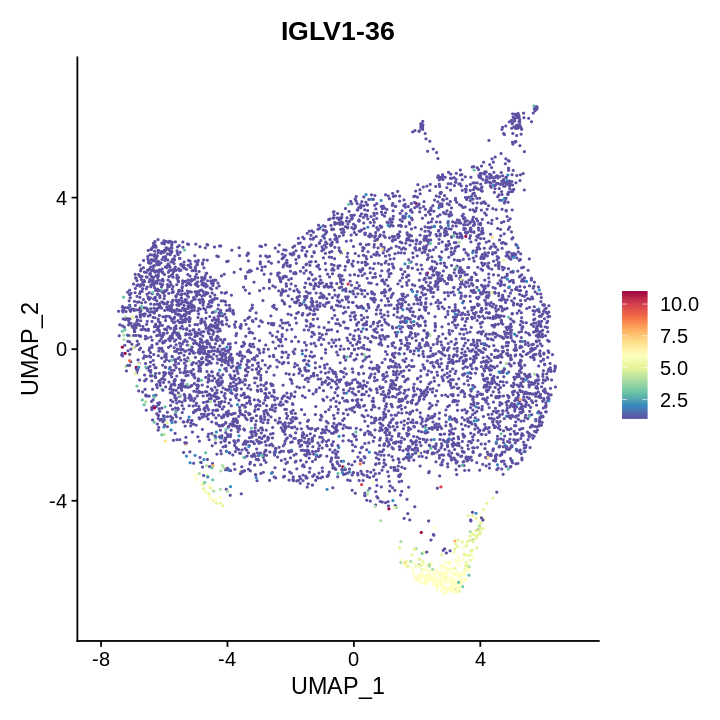

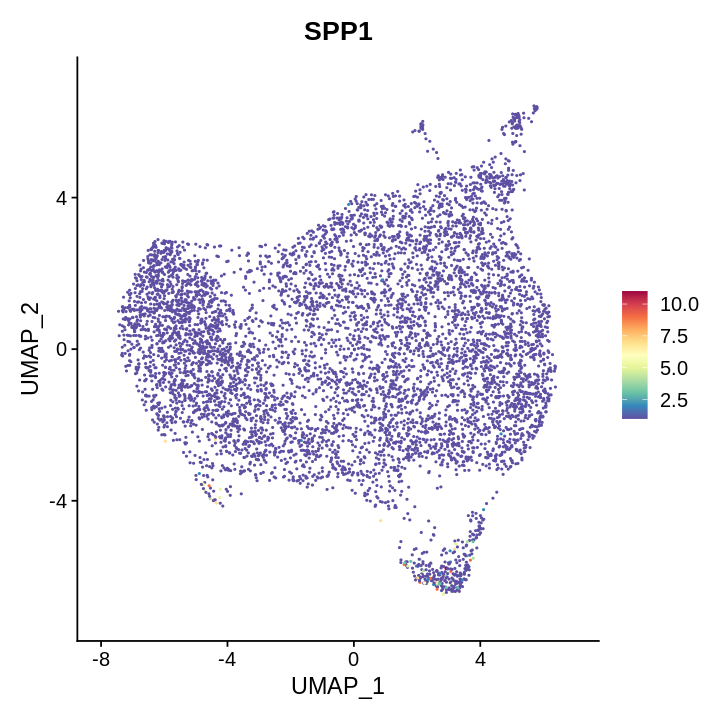

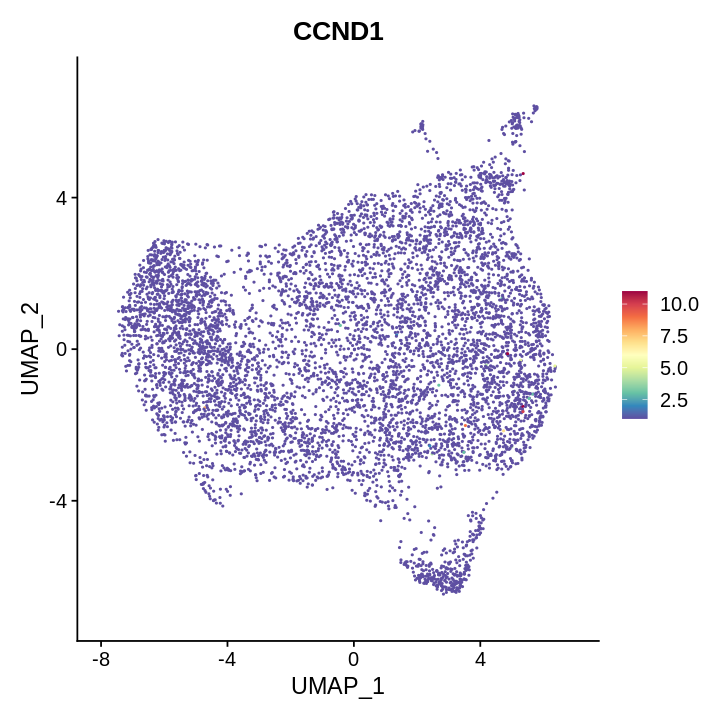

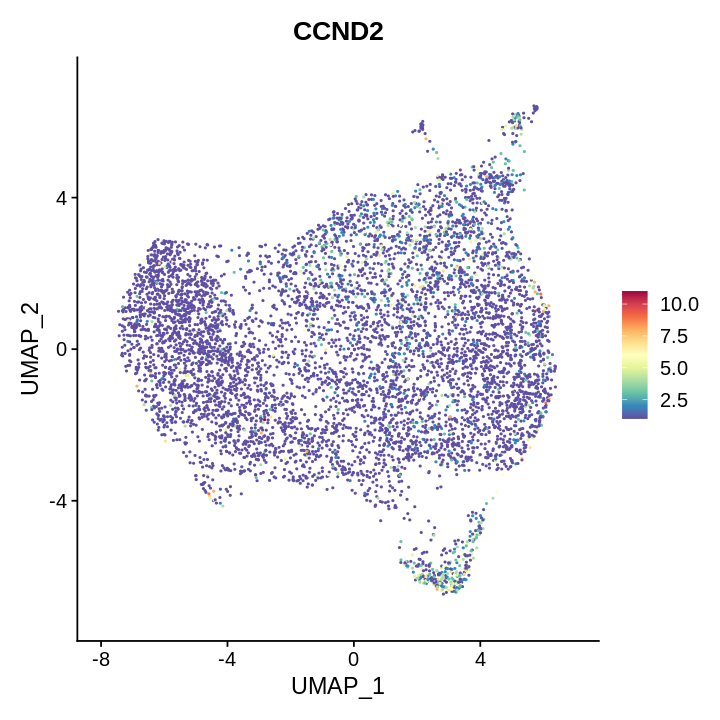

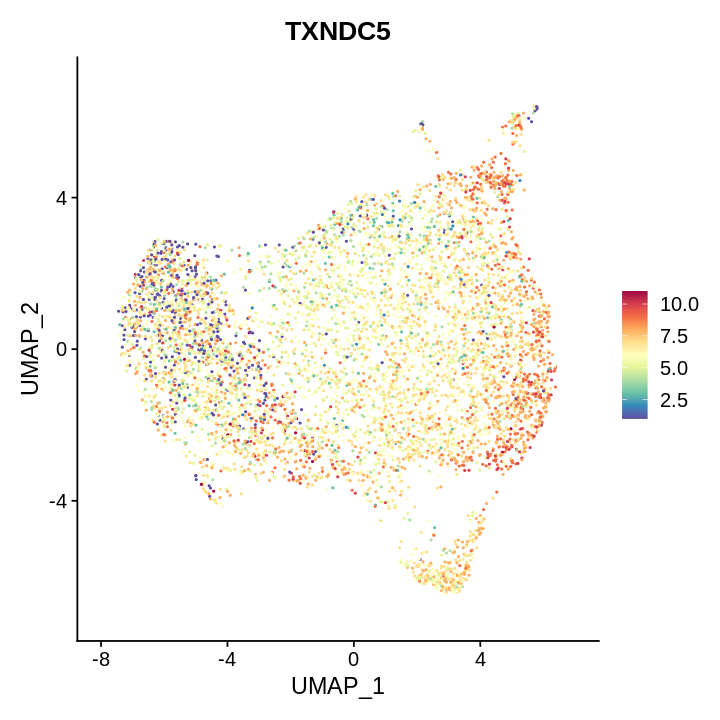

In [106]:
FeaturePlot(plasma, features = c('IGLV1-36'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('SPP1'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('CCND1'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('CCND2'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('TXNDC5'),cols=rev(brewer.pal(11,'Spectral')))

In [107]:
plasma.markers <- FindAllMarkers(plasma, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
plasma.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene      
1  1.405854e-14  0.3937795  0.216 0.348 2.457291e-10  0       IGLV1-47  
2  6.023741e-14  0.6396805  0.584 0.639 1.052890e-09  0       IGLV2-14  
3  7.960960e-13  0.2829240  0.298 0.473 1.391496e-08  0       IGHV3-21  
4  1.407784e-11  0.6666099  0.717 0.801 2.460665e-07  0       IGKV3-20  
5  1.484474e-09  0.3698089  0.298 0.446 2.594712e-05  0       IGLV6-57  
6  4.710773e-07  0.9853462  0.494 0.558 8.233959e-03  0       IGLV1-40  
7  1.086727e-05  0.5220258  0.488 0.707 1.899490e-01  0       IGLV3-1   
8  3.256721e-04  0.3323643  0.293 0.388 1.000000e+00  0       IGHV4-39  
9  5.612688e-03  0.3638626  0.237 0.311 1.000000e+00  0       IGLV2-8   
10 6.560151e-03  0.5804418  0.561 0.661 1.000000e+00  0       IGKV4-1   
11 1.666911e-22  0.6131684  0.735 0.589 2.913593e-18  1       IGLC2     
12 1.470109e-21  0.9077619  0.534 0.374 2.569604e-17  1       IGLC3     
13 6.231093e-16  1.2006079  0.398 0.276 1.089133e-11  1       IGLV2-8   
14 5.840971e-13  1.3076356  0.525 0.396 1.020943e-08  1       IGLV2-11  
15 4.945091e-11  0.5057196  0.678 0.526 8.643524e-07  1       IGHG2     
16 3.521680e-08  0.9532106  0.291 0.207 6.155544e-04  1       IGLV3-21  
17 2.851462e-04  0.8085913  0.696 0.656 1.000000e+00  1       IGLV3-1   
18 4.222660e-04  1.0386858  0.304 0.243 1.000000e+00  1       IGHA2     
19 3.546633e-03  0.7608522  0.426 0.357 1.000000e+00  1       IGHV4-39  
20 8.698643e-03  0.6464381  0.622 0.515 1.000000e+00  1       IGLV1-51  
21 5.360557e-23  1.2504817  0.331 0.186 9.369718e-19  2       IGKV1-17  
22 9.191273e-22  1.6411107  0.401 0.243 1.606543e-17  2       IGKV1-6   
23 4.966717e-21  1.2828933  0.344 0.201 8.681324e-17  2       IGKV1-9   
24 5.270953e-15  0.6365820  0.270 0.160 9.213100e-11  2       IGHV3-69-1
25 2.120738e-12  1.0930903  0.281 0.176 3.706838e-08  2       IGKV1-27  
26 1.240192e-11  0.6304987  0.290 0.183 2.167732e-07  2       IGKV1-16  
27 2.294535e-08  0.6358939  0.429 0.309 4.010618e-04  2       IGHV3-72  
28 1.618302e-07  0.4691839  0.545 0.420 2.828631e-03  2       IGHV3-7   
29 3.274169e-07  0.7857959  0.386 0.294 5.722921e-03  2       IGKV3D-20 
30 3.134300e-05  0.9058321  0.730 0.626 5.478443e-01  2       IGKV4-1   
⋮  ⋮             ⋮          ⋮     ⋮     ⋮             ⋮       ⋮         
61  6.094068e-77 0.6789303  0.844 0.442  1.065182e-72 6       KLF6      
62  2.789321e-64 0.6063597  0.962 0.622  4.875455e-60 6       DUSP1     
63  1.630410e-57 0.5862277  0.939 0.616  2.849793e-53 6       KLF2      
64  1.321102e-54 0.5225702  0.950 0.603  2.309154e-50 6       TSC22D3   
65  6.890307e-49 0.4597385  0.938 0.607  1.204357e-44 6       FOS       
66  1.303742e-48 0.4554310  0.986 0.677  2.278811e-44 6       JUND      
67  1.493685e-47 0.5147082  0.837 0.519  2.610812e-43 6       MT-ND3    
68  2.046873e-34 0.4524634  0.875 0.596  3.577730e-30 6       MT-CYB    
69  4.052642e-16 0.5158891  0.801 0.686  7.083613e-12 6       JCHAIN    
70  2.307248e-10 1.2192957  0.407 0.294  4.032839e-06 6       IGHM      
71  0.000000e+00 2.4966029  0.987 0.089  0.000000e+00 7       IGLV1-36  
72 2.104295e-253 2.1266537  0.997 0.290 3.678097e-249 7       IGLV1-47  
73 8.649967e-223 6.6524734  0.990 0.435 1.511928e-218 7       IGHV3-43  
74 1.311714e-208 2.0550402  0.936 0.253 2.292745e-204 7       PTP4A3    
75 7.938573e-207 3.0058471  0.946 0.353 1.387583e-202 7       SLC3A2    
76 3.959780e-193 2.2460545  1.000 0.453 6.921299e-189 7       IGLV1-44  
77 2.545886e-167 2.3259859  0.984 0.510 4.449955e-163 7       IGLC1     
78 2.228487e-158 1.9705017  0.997 0.908 3.895172e-154 7       DERL3     
79 1.530080e-127 1.8200062  0.990 0.616 2.674427e-123 7       IGHA1     
80 7.660198e-122 2.2867048  0.978 0.745 1.338926e-117 7       HSPA5     
81 6.336273e-255 4.9529238  0.452 0.007 1.107517e-250 8       NRGN      
82 6.108045e-209 3.7990122  0.274 0.002 1.067625e-204 8       PF4       
83 8.549885e-142 3.4502110  0.661 0.036 1.494434e-137 8      

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



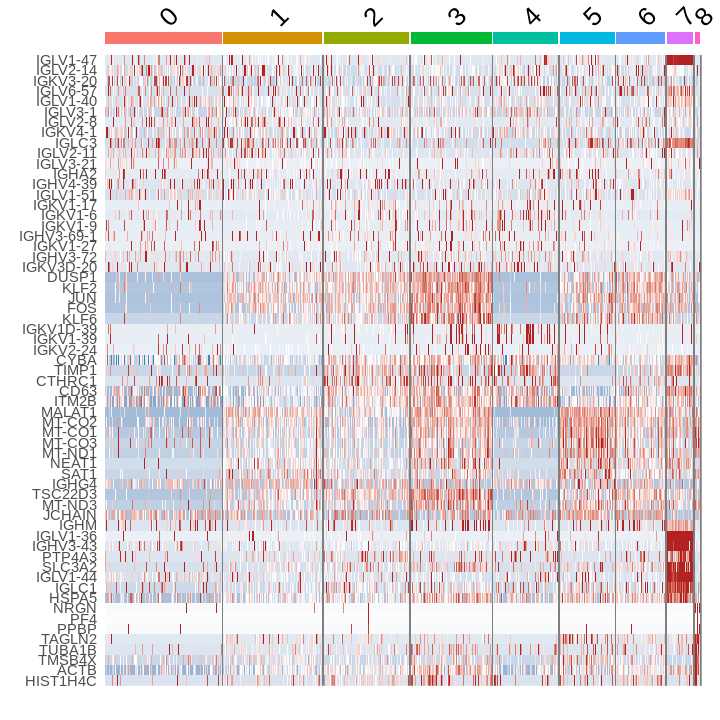

In [108]:
top10 <- plasma.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(plasma, features = top10$gene) + NoLegend()+ scale_fill_gradientn(colors = c("steelblue", "white", "firebrick"))

In [109]:
options(repr.plot.height=9,repr.plot.width=7)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



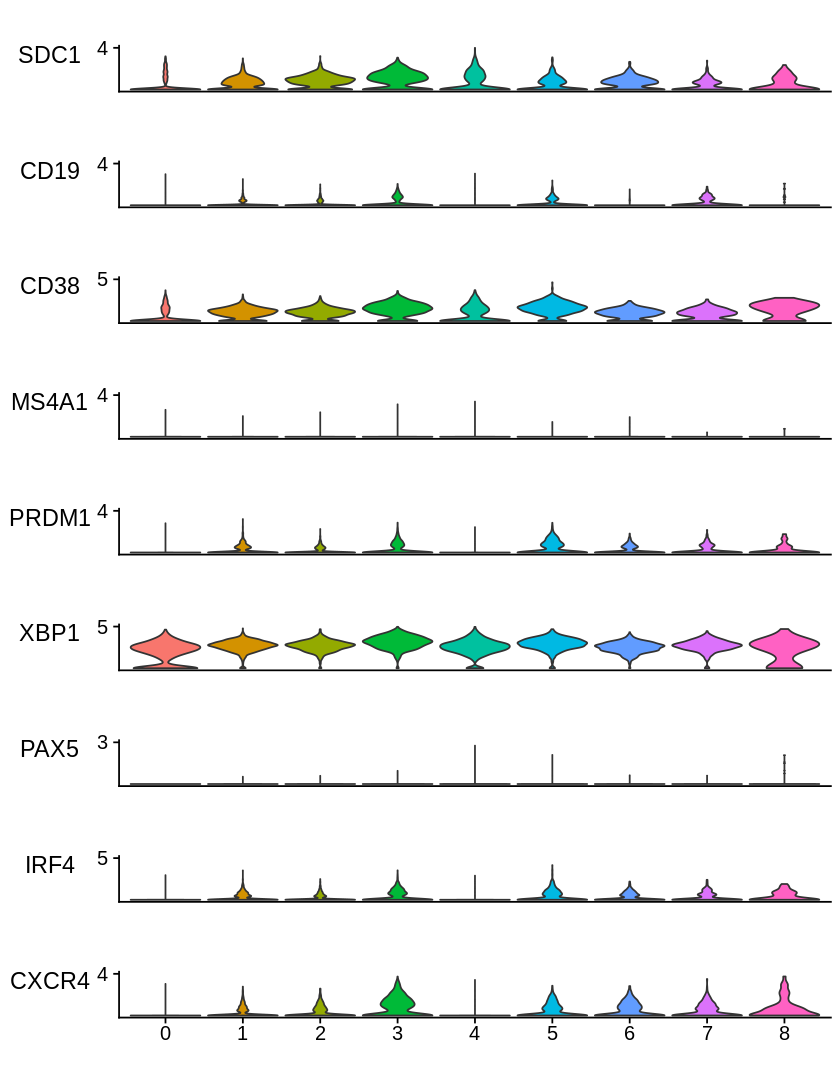

In [110]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



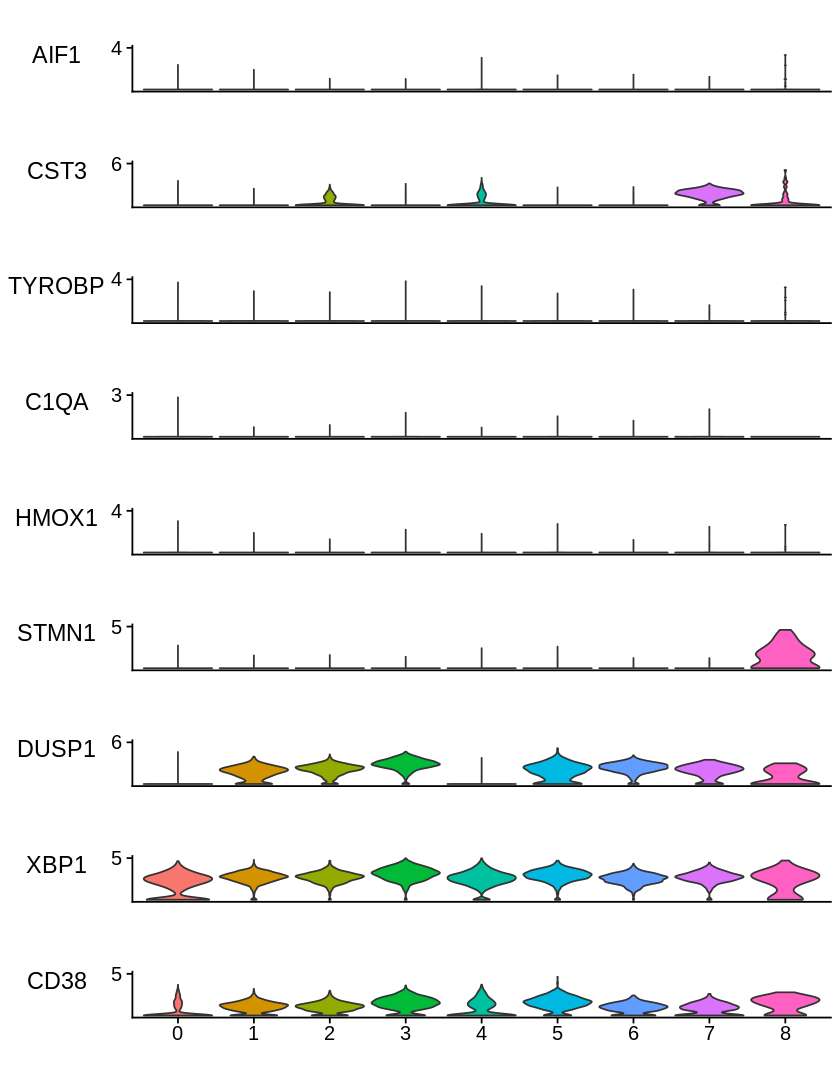

In [111]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =plasma, features = features)

In [112]:
options(repr.plot.height=6,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



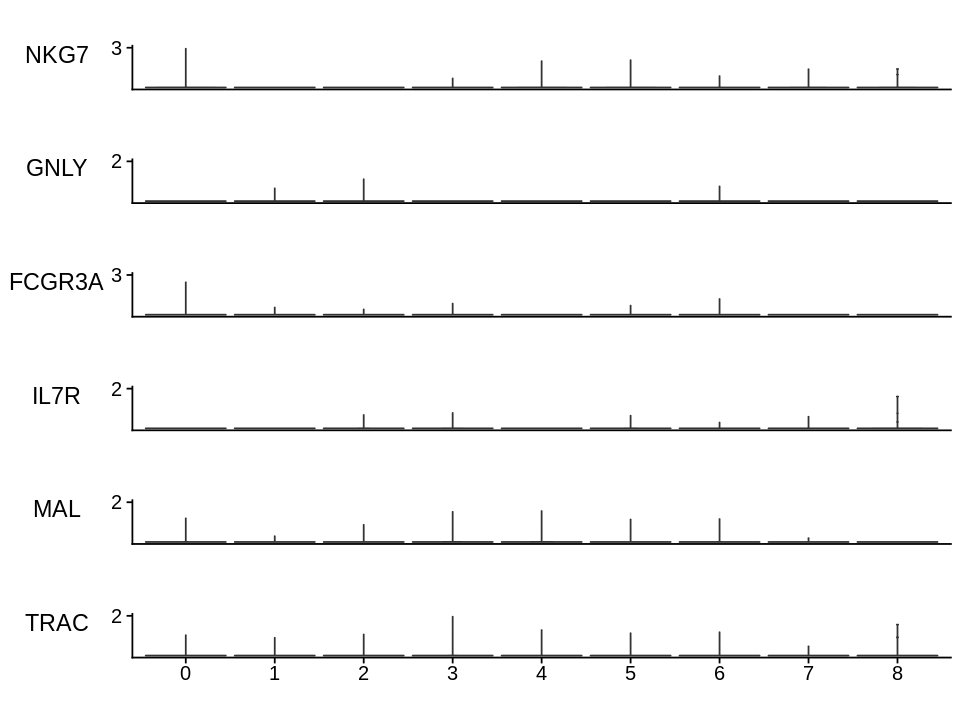

In [113]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', 

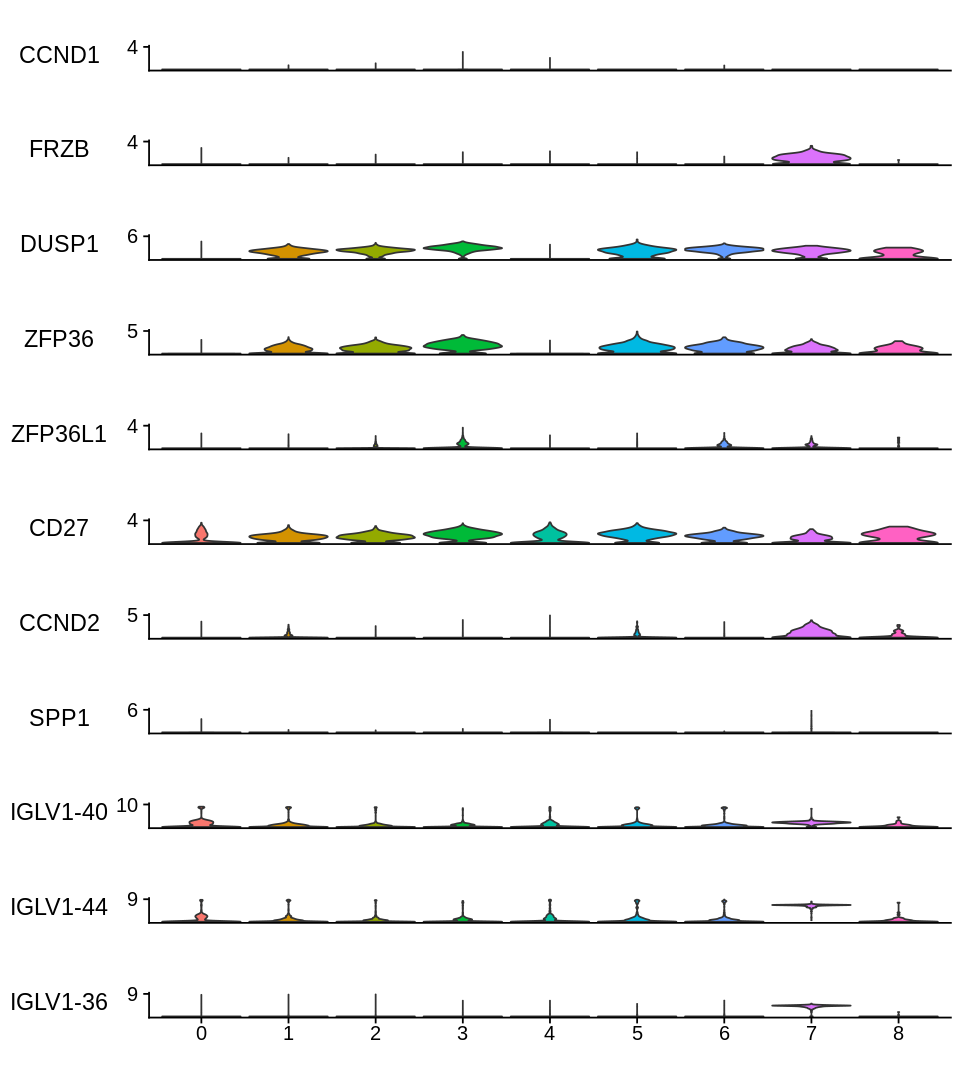

In [114]:
options(repr.plot.height=9,repr.plot.width=8)
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27","CCND2","SPP1","IGLV1-40","IGLV1-44","IGLV1-36")
StackedVlnPlot(obj =plasma, features = features)

In [115]:
save(plasma,file="0108-POEMS13-5.Rda")